In [1]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from datetime import datetime
from itertools import combinations

In [2]:
entrenamiento = pd.read_csv("../Train_TP2_Datos_2020-2C.csv")
test_real     = pd.read_csv("../Test_TP2_Datos_2020-2C.csv")

In [3]:
#LIMPIEZA

entrenamiento = entrenamiento[( entrenamiento['Stage'] == 'Closed Won') | ( entrenamiento['Stage'] == 'Closed Lost')]
entrenamiento = entrenamiento.loc[(entrenamiento["ASP_Currency"] == entrenamiento["Total_Taxable_Amount_Currency"])]
#entrenamiento = entrenamiento.loc[entrenamiento["Total_Taxable_Amount"] > 0]

def limpiar(x):
    x = x.drop(columns=['ASP_(converted)_Currency','Quote_Type','Brand','Product_Type','Size','Product_Category_B','Price','Currency','Last_Activity','Actual_Delivery_Date','Prod_Category_A'])
    x = x.drop(columns=['Opportunity_Name','Sales_Contract_No'])
    return x

entrenamiento = limpiar(entrenamiento)
test_real = limpiar(test_real)

In [4]:
#FORMATO FECHAS

#Respalda fecha, usada para separa set_train y set_test
entrenamiento['Fecha'] = pd.to_datetime(entrenamiento['Opportunity_Created_Date'])
columnas_fecha = ['Month','Last_Modified_Date','Account_Created_Date','Opportunity_Created_Date','Quote_Expiry_Date','Planned_Delivery_Start_Date','Planned_Delivery_End_Date']

def formato_fechas(x):
    for columna in columnas_fecha:
        x[columna] = pd.to_datetime(x[columna])
        
formato_fechas(entrenamiento)
formato_fechas(test_real)

In [5]:
#Nuevos Features
#Agrego feature: Duracion de la oportunidad
entrenamiento['Opportunity_Duration'] = (entrenamiento['Last_Modified_Date'] - entrenamiento['Opportunity_Created_Date']) / np.timedelta64(1, 'D')
test_real['Opportunity_Duration'] = (test_real['Last_Modified_Date'] - test_real['Opportunity_Created_Date']) / np.timedelta64(1, 'D')
#Agrego feature: Total_Amount_USD
entrenamiento["Total_Amount_USD"] = entrenamiento["Total_Amount"] * entrenamiento["ASP_(converted)"] / entrenamiento["ASP"]
test_real["Total_Amount_USD"] = test_real["Total_Amount"] * test_real["ASP_(converted)"] / test_real["ASP"]
#Agrego feature: Total_Taxable_Amount_USD
entrenamiento["Total_Taxable_Amount_USD"] = entrenamiento["Total_Taxable_Amount"] * entrenamiento["ASP_(converted)"] / entrenamiento["ASP"]
test_real["Total_Taxable_Amount_USD"] = test_real["Total_Taxable_Amount"] * test_real["ASP_(converted)"] / test_real["ASP"]
#Agrego feature: Total_Amount_sobre_Total_Taxable_Amount
entrenamiento["Total_Amount_sobre_Total_Taxable_Amount"] = entrenamiento["Total_Amount_USD"] / entrenamiento["Total_Taxable_Amount_USD"]
test_real["Total_Amount_sobre_Total_Taxable_Amount"] = test_real["Total_Amount_USD"] / test_real["Total_Taxable_Amount_USD"]

#Se debe solo usar los del train, no los del test, CAMBIAR
entrenamiento["Billing_Country_Vida_Util"] = entrenamiento.groupby("Billing_Country")["Opportunity_Duration"].transform("mean")
entrenamiento["Account_Type_Vida_Util"] = entrenamiento.groupby("Account_Type")["Opportunity_Duration"].transform("mean")
entrenamiento["Region_ASP"] = entrenamiento.groupby("Region")["ASP"].transform("mean")
entrenamiento["Billing_Country_ASP"] = entrenamiento.groupby("Billing_Country")["ASP"].transform("mean")
entrenamiento["Billing_Country_Total_Amount"] = entrenamiento.groupby("Billing_Country")["Total_Amount_USD"].transform("mean")
entrenamiento["Billing_Country_Buro"] = entrenamiento.groupby("Billing_Country")["Bureaucratic_Code_0_Approved"].transform("mean")
entrenamiento["Product_Family_Vida_Util"] = entrenamiento.groupby("Product_Family")["Opportunity_Duration"].transform("mean")
entrenamiento["Product_Family_Total_Amount"] = entrenamiento.groupby("Product_Family")["Total_Amount"].transform("mean")
entrenamiento["Product_Family_Buro"] = entrenamiento.groupby("Product_Family")["Bureaucratic_Code_0_Approved"].transform("mean")


In [6]:

#Agrego feature: Duracion por region
duracion_region = pd.read_csv('duracion_region.csv')
entrenamiento = entrenamiento.merge(duracion_region,on='Region',how='left')
test_real = test_real.merge(duracion_region,on='Region',how='left')

#Agrego feature: Duracion por territorio
duracion_territorio = pd.read_csv('duracion_territorio.csv')
entrenamiento = entrenamiento.merge(duracion_territorio,on='Territory',how='left')
test_real = test_real.merge(duracion_territorio,on='Territory',how='left')

#Agrego feature: Comportamiento segun territorio
comportamiento_territorio =  pd.read_csv('comportamiento_territorio.csv')
entrenamiento = entrenamiento.merge(comportamiento_territorio,on='Territory',how='left')
test_real = test_real.merge(comportamiento_territorio,on='Territory',how='left')

In [7]:
#FECHAS A DIAS
def fecha_a_dias(x):
    for columna in columnas_fecha:
        x[columna] = x[columna].apply(lambda x : (x - pd.to_datetime('01/01/2000', format='%m/%d/%Y')).days)

fecha_a_dias(entrenamiento)
fecha_a_dias(test_real)

In [8]:
#QUITO STAGE
#objetivo = entrenamiento.pop('Stage')
#objetivo = objetivo.apply(lambda x : int(x == 'Closed Won'))
#objetivo

In [9]:
#Division entre set_datos y set_test

set_train = entrenamiento.loc[entrenamiento['Fecha'].dt.year == 2015]
set_test = entrenamiento.loc[entrenamiento['Fecha'].dt.year == 2016]
set_train["label"] = (set_train['Stage'] == 'Closed Won').astype(int)
set_train_label = (set_train['Stage'] == 'Closed Won').astype(int)
set_test_label = (set_test['Stage'] == 'Closed Won').astype(int)



<ipython-input-9-2a23c01ce1f5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_train["label"] = (set_train['Stage'] == 'Closed Won').astype(int)


In [10]:
set_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1007 entries, 0 to 16851
Data columns (total 67 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   ID                                       1007 non-null   int64         
 1   Region                                   1007 non-null   object        
 2   Territory                                1007 non-null   object        
 3   Pricing, Delivery_Terms_Quote_Appr       1007 non-null   int64         
 4   Pricing, Delivery_Terms_Approved         1007 non-null   int64         
 5   Bureaucratic_Code_0_Approval             1007 non-null   int64         
 6   Bureaucratic_Code_0_Approved             1007 non-null   int64         
 7   Submitted_for_Approval                   1007 non-null   int64         
 8   Bureaucratic_Code                        1007 non-null   object        
 9   Account_Created_Date                    

In [11]:
"""Se debe pasar train y test ordenados """
def expansion_mean_encoding(columnas_categoricas,train,test,label):
    #Dividimos el dataset de entrenamiento en features y labels
    #Armo un df extra que me ayudara para codificar las categoricas.
    #x_y_train = filtrado.iloc[:-test_rows]
    #x_train = x_y_train.drop('Stage', axis=1)
    #y_train = x_y_train['Stage'].to_frame()
    #x_test = filtrado.iloc[-test_rows:].drop('Stage', axis=1)
    #y_test = filtrado.iloc[-test_rows:]['Stage'].to_frame()

    #En el set de train.
    #columnas_categoricas = x_train.select_dtypes(include='category').columns

    codificaciones = dict()

    for col in columnas_categoricas:
        last_one = train.groupby(col).tail(1)
        for (idx, reg) in zip(last_one[col].index, last_one[col].values):
            codificaciones[reg] = (col, idx)
        cumulative_sum = train.groupby(col)[label].cumsum() - train[label]
        cumulative_count = train.groupby(col).cumcount()
        train[col] = cumulative_sum/cumulative_count

    #Llenamos los NaN generados por cumsum con ceros.
    train.fillna(0,inplace = True)

    #Guardamos la codificacion de cada categoria segun su nombre.
    for k, v in codificaciones.items():
        col = v[0]
        idx = v[1]
        codificaciones[k] = train.loc[idx, col]
    
    # Utilizo las ultimas codificaciones de cada categoria del train set para codificar el test set.
    # Para eso utilizo el diccionario de codificaciones.

    #columnas_categoricas = x_test.select_dtypes(include='category').columns

    for col in columnas_categoricas:
        test[col] = test[col].astype(object)
        for (idx, reg) in zip(test[col].index, test[col]):
            if (reg in codificaciones):
                test.loc[idx, col] = codificaciones[reg]
            else:
                #Codifico como cero, se puede mejorar
                test.loc[idx, col] = 0
        test[col] = test[col].astype(float)   

In [12]:
entrenamiento.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16852 entries, 0 to 16851
Data columns (total 66 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   ID                                       16852 non-null  int64         
 1   Region                                   16852 non-null  object        
 2   Territory                                16852 non-null  object        
 3   Pricing, Delivery_Terms_Quote_Appr       16852 non-null  int64         
 4   Pricing, Delivery_Terms_Approved         16852 non-null  int64         
 5   Bureaucratic_Code_0_Approval             16852 non-null  int64         
 6   Bureaucratic_Code_0_Approved             16852 non-null  int64         
 7   Submitted_for_Approval                   16852 non-null  int64         
 8   Bureaucratic_Code                        16852 non-null  object        
 9   Account_Created_Date                   

In [13]:
set_train.sort_values("Fecha")
columnas_categoricas = list(set_train.select_dtypes(include=['object']).columns)
expansion_mean_encoding(columnas_categoricas,set_train,set_test,"label")

<ipython-input-11-99f73d816aed>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col] = cumulative_sum/cumulative_count
C:\Users\gianb\anaconda3\lib\site-packages\pandas\core\frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-11-99f73d816aed>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

In [14]:
#CATEGORICAS A NUMERICAS  - TEMP
def categoricas_a_numericas(x):
    ohe = skl.preprocessing.OrdinalEncoder()
    columnas_object = list(x.select_dtypes(include=['object']).columns)
    if 'Stage' in columnas_object : columnas_object.remove('Stage')
    for columna in columnas_object:
        copia = x[[columna]].copy().dropna()
        df_temp = pd.DataFrame(ohe.fit_transform(copia)).astype('int32')
        df_temp.columns = [columna]
        x[columna] = df_temp[columna]

categoricas_a_numericas(entrenamiento)
categoricas_a_numericas(test_real)
categoricas_a_numericas(set_train)
categoricas_a_numericas(set_test)

In [15]:
#Filtrado de columnas - No remover Stage o Fecha
#entrenamiento = entrenamiento[['Total_Amount_Currency']]

In [16]:
set_train = xgb.DMatrix(set_train.drop(columns=['Stage','Fecha',"label"]),label = set_train_label)
set_test  = xgb.DMatrix(set_test .drop(columns=['Stage','Fecha']),label = set_test_label)
evaluacion = [(set_test, 'eval'), (set_train, 'train')]

#entrenamiento = entrenamiento.drop(columns=['Fecha','Stage'])

[19:56:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.72139	train-logloss:0.43052
[1]	eval-logloss:0.77265	train-logloss:0.30436
[2]	eval-logloss:0.84293	train-logloss:0.23283
[3]	eval-logloss:0.88227	train-logloss:0.18632
[4]	eval-logloss:0.79356	train-logloss:0.15585
[5]	eval-logloss:0.72632	train-logloss:0.13413
[6]	eval-logloss:0.63717	train-logloss:0.10659
[7]	eval-logloss:0.58787	train-logloss:0.09298
[8]	eval-logloss:0.54325	train-logloss:0.07729
[9]	eval-logloss:0.51077	train-logloss:0.06882
[10]	eval-logloss:0.49537	train-logloss:0.06151
[11]	eval-logloss:0.50582	train-logloss:0.05377
[12]	eval-logloss:0.47800	train-logloss:0.04695
[13]	eval-logloss:0.45112	train-logloss:0.04182
[14]	eval-logloss:0.43515	tr

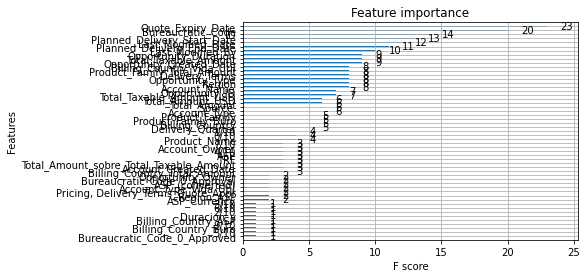

In [21]:
parametros = {"booster":"gbtree", "max_depth":4, "eta": 0.4, "objective": "binary:logistic", "nthread":2,"gamma" : 0}
rondas = 30

modelo = xgb.train(parametros, set_train, rondas, evaluacion)

xgb.plot_importance(modelo)
plt.show()

In [22]:
prediccion = modelo.predict(set_test)

prediccion = [1 if i > .5 else 0 for i in prediccion]

def metricas(objetivo, prediccion):
    matriz_conf = confusion_matrix(objetivo, prediccion)
    score = accuracy_score(objetivo, prediccion)
    reporte = classification_report(objetivo, prediccion)
    metricas = [matriz_conf, score, reporte]
    return(metricas)

metrics = metricas(set_test_label, prediccion)
print("Prediccion Test")
[print(i) for i in metrics]
print(skl.metrics.log_loss(set_test_label,prediccion))

prediccion = modelo.predict(set_train)
prediccion = [1 if i > .5 else 0 for i in prediccion]
metricas = metricas(set_train_label, prediccion)
print("Prediccion Train")
[print(i) for i in metricas]

Prediccion Test
[[1789  462]
 [ 273 1822]]
0.8308789691670502
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      2251
           1       0.80      0.87      0.83      2095

    accuracy                           0.83      4346
   macro avg       0.83      0.83      0.83      4346
weighted avg       0.83      0.83      0.83      4346

5.84131846853937
Prediccion Train
[[732   0]
 [  0 275]]
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       732
           1       1.00      1.00      1.00       275

    accuracy                           1.00      1007
   macro avg       1.00      1.00      1.00      1007
weighted avg       1.00      1.00      1.00      1007



[None, None, None]

In [20]:
"""min_log_loss = 1000
d = 1000
e = 1000
r = 1000
for depth in range(2,14):
    for eta in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
        for rondas in [10,20,30,40]:
            parametros = {"booster":"gbtree", "max_depth":depth, "eta": eta, "objective": "binary:logistic", "nthread":2}
            modelo = xgb.train(parametros, set_train, rondas, evaluacion)
            prediccion = modelo.predict(set_test)
            prediccion = [1 if i > .5 else 0 for i in prediccion]
            log_loss = skl.metrics.log_loss(set_test_label,prediccion)
            if (log_loss < min_log_loss):
                min_log_loss = log_loss
                d = depth
                e = eta
                r = rondas


print("log: ",min_log_loss)                
print("depth: ",d)      
print("eta: ",e)      
print("rondas: ",r)"""

[19:55:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.68995	train-logloss:0.62588
[1]	eval-logloss:0.69072	train-logloss:0.57077
[2]	eval-logloss:0.69446	train-logloss:0.52496
[3]	eval-logloss:0.70043	train-logloss:0.48641
[4]	eval-logloss:0.70801	train-logloss:0.45371
[5]	eval-logloss:0.71694	train-logloss:0.42566
[6]	eval-logloss:0.72675	train-logloss:0.40103
[7]	eval-logloss:0.73799	train-logloss:0.37956
[8]	eval-logloss:0.74859	train-logloss:0.36050
[9]	eval-logloss:0.75167	train-logloss:0.34350
[19:55:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'e

[19:56:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.69100	train-logloss:0.56554
[1]	eval-logloss:0.70178	train-logloss:0.48016
[2]	eval-logloss:0.71942	train-logloss:0.41968
[3]	eval-logloss:0.74204	train-logloss:0.37374
[4]	eval-logloss:0.76448	train-logloss:0.33852
[5]	eval-logloss:0.77156	train-logloss:0.31026
[6]	eval-logloss:0.74220	train-logloss:0.28211
[7]	eval-logloss:0.69827	train-logloss:0.26315
[8]	eval-logloss:0.70115	train-logloss:0.24761
[9]	eval-logloss:0.67148	train-logloss:0.23408
[10]	eval-logloss:0.64496	train-logloss:0.22139
[11]	eval-logloss:0.61769	train-logloss:0.21086
[12]	eval-logloss:0.59533	train-logloss:0.20080
[13]	eval-logloss:0.58762	train-logloss:0.19309
[14]	eval-logloss:0.55815	tr

[4]	eval-logloss:0.72614	train-logloss:0.27358
[5]	eval-logloss:0.68918	train-logloss:0.24263
[6]	eval-logloss:0.67855	train-logloss:0.22027
[7]	eval-logloss:0.64005	train-logloss:0.20438
[8]	eval-logloss:0.60417	train-logloss:0.19165
[9]	eval-logloss:0.60748	train-logloss:0.18038
[10]	eval-logloss:0.56336	train-logloss:0.17141
[11]	eval-logloss:0.55626	train-logloss:0.16415
[12]	eval-logloss:0.53341	train-logloss:0.15698
[13]	eval-logloss:0.53370	train-logloss:0.15143
[14]	eval-logloss:0.51334	train-logloss:0.14553
[15]	eval-logloss:0.50530	train-logloss:0.14007
[16]	eval-logloss:0.49800	train-logloss:0.13514
[17]	eval-logloss:0.49893	train-logloss:0.13216
[18]	eval-logloss:0.49966	train-logloss:0.12962
[19]	eval-logloss:0.48574	train-logloss:0.12601
[20]	eval-logloss:0.47080	train-logloss:0.12011
[21]	eval-logloss:0.48123	train-logloss:0.11665
[22]	eval-logloss:0.47667	train-logloss:0.11406
[23]	eval-logloss:0.47405	train-logloss:0.11092
[24]	eval-logloss:0.47364	train-logloss:0.1082

[4]	eval-logloss:0.69684	train-logloss:0.20579
[5]	eval-logloss:0.69752	train-logloss:0.18557
[6]	eval-logloss:0.70000	train-logloss:0.17018
[7]	eval-logloss:0.63664	train-logloss:0.15511
[8]	eval-logloss:0.58125	train-logloss:0.14217
[9]	eval-logloss:0.58345	train-logloss:0.13343
[19:56:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.71885	train-logloss:0.42403
[1]	eval-logloss:0.78883	train-logloss:0.32287
[2]	eval-logloss:0.85389	train-logloss:0.26830
[3]	eval-logloss:0.76236	train-logloss:0.23114
[4]	eval-logloss:0.69684	train-logloss:0.20579
[5]	eval-logloss:0.69752	train-logloss:0.18557
[6]	eval-logloss:0.70000	train-logloss:0.17018
[7]	eval-logloss:0.63664	train-logloss:0.15511
[8]	eval-logloss:0.58125	train-l

[8]	eval-logloss:0.51428	train-logloss:0.12777
[9]	eval-logloss:0.53532	train-logloss:0.11961
[10]	eval-logloss:0.53684	train-logloss:0.11235
[11]	eval-logloss:0.52911	train-logloss:0.10782
[12]	eval-logloss:0.53265	train-logloss:0.10187
[13]	eval-logloss:0.51526	train-logloss:0.09538
[14]	eval-logloss:0.51638	train-logloss:0.09153
[15]	eval-logloss:0.51681	train-logloss:0.08848
[16]	eval-logloss:0.50703	train-logloss:0.08329
[17]	eval-logloss:0.51406	train-logloss:0.07942
[18]	eval-logloss:0.52011	train-logloss:0.07502
[19]	eval-logloss:0.51082	train-logloss:0.07085
[20]	eval-logloss:0.51205	train-logloss:0.06737
[21]	eval-logloss:0.53998	train-logloss:0.06345
[22]	eval-logloss:0.56624	train-logloss:0.06052
[23]	eval-logloss:0.57834	train-logloss:0.05722
[24]	eval-logloss:0.54735	train-logloss:0.05438
[25]	eval-logloss:0.56189	train-logloss:0.05200
[26]	eval-logloss:0.54661	train-logloss:0.04933
[27]	eval-logloss:0.53708	train-logloss:0.04658
[28]	eval-logloss:0.54480	train-logloss:0.

[18]	eval-logloss:0.54565	train-logloss:0.06124
[19]	eval-logloss:0.55344	train-logloss:0.05772
[20]	eval-logloss:0.58934	train-logloss:0.05429
[21]	eval-logloss:0.56327	train-logloss:0.05109
[22]	eval-logloss:0.55134	train-logloss:0.04827
[23]	eval-logloss:0.52656	train-logloss:0.04506
[24]	eval-logloss:0.51608	train-logloss:0.04351
[25]	eval-logloss:0.53497	train-logloss:0.04083
[26]	eval-logloss:0.56034	train-logloss:0.03836
[27]	eval-logloss:0.54807	train-logloss:0.03686
[28]	eval-logloss:0.58167	train-logloss:0.03542
[29]	eval-logloss:0.57317	train-logloss:0.03361
[30]	eval-logloss:0.58153	train-logloss:0.03198
[31]	eval-logloss:0.57171	train-logloss:0.03121
[32]	eval-logloss:0.55382	train-logloss:0.02975
[33]	eval-logloss:0.56535	train-logloss:0.02845
[34]	eval-logloss:0.57468	train-logloss:0.02738
[35]	eval-logloss:0.58388	train-logloss:0.02603
[36]	eval-logloss:0.59138	train-logloss:0.02524
[37]	eval-logloss:0.58316	train-logloss:0.02410
[38]	eval-logloss:0.59031	train-logloss:

[1]	eval-logloss:0.86046	train-logloss:0.22475
[2]	eval-logloss:0.72249	train-logloss:0.18843
[3]	eval-logloss:0.57107	train-logloss:0.16401
[4]	eval-logloss:0.58171	train-logloss:0.14331
[5]	eval-logloss:0.58648	train-logloss:0.12798
[6]	eval-logloss:0.51075	train-logloss:0.11416
[7]	eval-logloss:0.53615	train-logloss:0.10459
[8]	eval-logloss:0.54117	train-logloss:0.09853
[9]	eval-logloss:0.52235	train-logloss:0.09074
[10]	eval-logloss:0.51413	train-logloss:0.08495
[11]	eval-logloss:0.51797	train-logloss:0.07973
[12]	eval-logloss:0.53343	train-logloss:0.07482
[13]	eval-logloss:0.51949	train-logloss:0.06946
[14]	eval-logloss:0.50005	train-logloss:0.06367
[15]	eval-logloss:0.50688	train-logloss:0.05869
[16]	eval-logloss:0.48328	train-logloss:0.05340
[17]	eval-logloss:0.50787	train-logloss:0.04927
[18]	eval-logloss:0.53444	train-logloss:0.04667
[19]	eval-logloss:0.57351	train-logloss:0.04346
[19:56:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1

[21]	eval-logloss:0.59687	train-logloss:0.02927
[22]	eval-logloss:0.59600	train-logloss:0.02738
[23]	eval-logloss:0.60309	train-logloss:0.02558
[24]	eval-logloss:0.60237	train-logloss:0.02432
[25]	eval-logloss:0.60110	train-logloss:0.02314
[26]	eval-logloss:0.61741	train-logloss:0.02164
[27]	eval-logloss:0.62161	train-logloss:0.01965
[28]	eval-logloss:0.62149	train-logloss:0.01871
[29]	eval-logloss:0.62124	train-logloss:0.01777
[19:56:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.83798	train-logloss:0.29658
[1]	eval-logloss:0.89602	train-logloss:0.21408
[2]	eval-logloss:0.71843	train-logloss:0.17500
[3]	eval-logloss:0.60107	train-logloss:0.15117
[4]	eval-logloss:0.59795	train-logloss:0.13503
[5]	eval-logloss:0.6423

[31]	eval-logloss:0.49394	train-logloss:0.12897
[32]	eval-logloss:0.48772	train-logloss:0.12616
[33]	eval-logloss:0.48473	train-logloss:0.12282
[34]	eval-logloss:0.48344	train-logloss:0.12029
[35]	eval-logloss:0.47415	train-logloss:0.11690
[36]	eval-logloss:0.47432	train-logloss:0.11423
[37]	eval-logloss:0.46694	train-logloss:0.11165
[38]	eval-logloss:0.46137	train-logloss:0.10909
[39]	eval-logloss:0.45438	train-logloss:0.10644
[19:56:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.70044	train-logloss:0.55474
[1]	eval-logloss:0.71098	train-logloss:0.46152
[2]	eval-logloss:0.73199	train-logloss:0.39276
[3]	eval-logloss:0.74713	train-logloss:0.34185
[4]	eval-logloss:0.77060	train-logloss:0.30222
[5]	eval-logloss:0.7839

[15]	eval-logloss:0.44677	train-logloss:0.08494
[16]	eval-logloss:0.44072	train-logloss:0.08019
[17]	eval-logloss:0.42918	train-logloss:0.07514
[18]	eval-logloss:0.42735	train-logloss:0.07212
[19]	eval-logloss:0.41882	train-logloss:0.06781
[19:56:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.70988	train-logloss:0.49657
[1]	eval-logloss:0.73027	train-logloss:0.38526
[2]	eval-logloss:0.76803	train-logloss:0.31516
[3]	eval-logloss:0.78783	train-logloss:0.26389
[4]	eval-logloss:0.71742	train-logloss:0.22404
[5]	eval-logloss:0.66222	train-logloss:0.19594
[6]	eval-logloss:0.61349	train-logloss:0.17537
[7]	eval-logloss:0.56872	train-logloss:0.15356
[8]	eval-logloss:0.53730	train-logloss:0.14145
[9]	eval-logloss:0.50472	tr

[19:56:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.72298	train-logloss:0.44538
[1]	eval-logloss:0.75972	train-logloss:0.32841
[2]	eval-logloss:0.65870	train-logloss:0.25944
[3]	eval-logloss:0.59077	train-logloss:0.21382
[4]	eval-logloss:0.61120	train-logloss:0.18371
[5]	eval-logloss:0.56592	train-logloss:0.15722
[6]	eval-logloss:0.52919	train-logloss:0.13946
[7]	eval-logloss:0.50995	train-logloss:0.12323
[8]	eval-logloss:0.51146	train-logloss:0.11414
[9]	eval-logloss:0.47072	train-logloss:0.10169
[10]	eval-logloss:0.44969	train-logloss:0.09147
[11]	eval-logloss:0.45288	train-logloss:0.08484
[12]	eval-logloss:0.44248	train-logloss:0.07725
[13]	eval-logloss:0.43529	train-logloss:0.07184
[14]	eval-logloss:0.42475	tr

[19:56:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.75935	train-logloss:0.36227
[1]	eval-logloss:0.61994	train-logloss:0.25182
[2]	eval-logloss:0.52897	train-logloss:0.19551
[3]	eval-logloss:0.46568	train-logloss:0.15483
[4]	eval-logloss:0.44400	train-logloss:0.13357
[5]	eval-logloss:0.42971	train-logloss:0.11303
[6]	eval-logloss:0.41168	train-logloss:0.10005
[7]	eval-logloss:0.40078	train-logloss:0.08711
[8]	eval-logloss:0.39429	train-logloss:0.07508
[9]	eval-logloss:0.40199	train-logloss:0.06829
[19:56:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'e

[0]	eval-logloss:0.78209	train-logloss:0.32936
[1]	eval-logloss:0.63501	train-logloss:0.22005
[2]	eval-logloss:0.53807	train-logloss:0.17114
[3]	eval-logloss:0.47448	train-logloss:0.13474
[4]	eval-logloss:0.45188	train-logloss:0.10699
[5]	eval-logloss:0.43105	train-logloss:0.09460
[6]	eval-logloss:0.41098	train-logloss:0.08187
[7]	eval-logloss:0.43620	train-logloss:0.07285
[8]	eval-logloss:0.45734	train-logloss:0.06657
[9]	eval-logloss:0.46069	train-logloss:0.05864
[10]	eval-logloss:0.48182	train-logloss:0.05359
[11]	eval-logloss:0.48162	train-logloss:0.04961
[12]	eval-logloss:0.50380	train-logloss:0.04520
[13]	eval-logloss:0.51084	train-logloss:0.04175
[14]	eval-logloss:0.49873	train-logloss:0.03717
[15]	eval-logloss:0.51050	train-logloss:0.03246
[16]	eval-logloss:0.53174	train-logloss:0.02842
[17]	eval-logloss:0.54686	train-logloss:0.02623
[18]	eval-logloss:0.53206	train-logloss:0.02454
[19]	eval-logloss:0.52553	train-logloss:0.02186
[20]	eval-logloss:0.50791	train-logloss:0.02006
[2

[10]	eval-logloss:0.59234	train-logloss:0.03961
[11]	eval-logloss:0.60553	train-logloss:0.03299
[12]	eval-logloss:0.58938	train-logloss:0.02941
[13]	eval-logloss:0.57335	train-logloss:0.02614
[14]	eval-logloss:0.56878	train-logloss:0.02286
[15]	eval-logloss:0.57226	train-logloss:0.02126
[16]	eval-logloss:0.56460	train-logloss:0.01931
[17]	eval-logloss:0.57877	train-logloss:0.01818
[18]	eval-logloss:0.58251	train-logloss:0.01682
[19]	eval-logloss:0.58134	train-logloss:0.01496
[20]	eval-logloss:0.60224	train-logloss:0.01386
[21]	eval-logloss:0.61584	train-logloss:0.01316
[22]	eval-logloss:0.60836	train-logloss:0.01210
[23]	eval-logloss:0.62017	train-logloss:0.01135
[24]	eval-logloss:0.61794	train-logloss:0.01076
[25]	eval-logloss:0.61693	train-logloss:0.01024
[26]	eval-logloss:0.60684	train-logloss:0.00958
[27]	eval-logloss:0.60603	train-logloss:0.00920
[28]	eval-logloss:0.61508	train-logloss:0.00851
[29]	eval-logloss:0.61950	train-logloss:0.00805
[30]	eval-logloss:0.62165	train-logloss:

[19:56:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.86540	train-logloss:0.25882
[1]	eval-logloss:0.65817	train-logloss:0.17589
[2]	eval-logloss:0.51043	train-logloss:0.13222
[3]	eval-logloss:0.46773	train-logloss:0.10325
[4]	eval-logloss:0.45732	train-logloss:0.08703
[5]	eval-logloss:0.49280	train-logloss:0.06952
[6]	eval-logloss:0.47531	train-logloss:0.05714
[7]	eval-logloss:0.48294	train-logloss:0.04966
[8]	eval-logloss:0.45756	train-logloss:0.04048
[9]	eval-logloss:0.47326	train-logloss:0.03495
[10]	eval-logloss:0.46614	train-logloss:0.02941
[11]	eval-logloss:0.47225	train-logloss:0.02516
[12]	eval-logloss:0.48716	train-logloss:0.02252
[13]	eval-logloss:0.50209	train-logloss:0.01972
[14]	eval-logloss:0.50970	tr

[14]	eval-logloss:0.80112	train-logloss:0.20934
[15]	eval-logloss:0.77695	train-logloss:0.19798
[16]	eval-logloss:0.75440	train-logloss:0.18837
[17]	eval-logloss:0.73272	train-logloss:0.17923
[18]	eval-logloss:0.72480	train-logloss:0.17112
[19]	eval-logloss:0.70453	train-logloss:0.16340
[20]	eval-logloss:0.68434	train-logloss:0.15615
[21]	eval-logloss:0.69399	train-logloss:0.14995
[22]	eval-logloss:0.67698	train-logloss:0.14469
[23]	eval-logloss:0.66098	train-logloss:0.13900
[24]	eval-logloss:0.64642	train-logloss:0.13404
[25]	eval-logloss:0.63009	train-logloss:0.12768
[26]	eval-logloss:0.61593	train-logloss:0.12270
[27]	eval-logloss:0.60093	train-logloss:0.11871
[28]	eval-logloss:0.58222	train-logloss:0.11242
[29]	eval-logloss:0.56928	train-logloss:0.10846
[19:56:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'lo

[24]	eval-logloss:0.46440	train-logloss:0.05236
[25]	eval-logloss:0.45517	train-logloss:0.05007
[26]	eval-logloss:0.44859	train-logloss:0.04725
[27]	eval-logloss:0.45285	train-logloss:0.04388
[28]	eval-logloss:0.45019	train-logloss:0.04160
[29]	eval-logloss:0.44757	train-logloss:0.04007
[30]	eval-logloss:0.44443	train-logloss:0.03830
[31]	eval-logloss:0.43683	train-logloss:0.03633
[32]	eval-logloss:0.43334	train-logloss:0.03498
[33]	eval-logloss:0.43121	train-logloss:0.03349
[34]	eval-logloss:0.43263	train-logloss:0.03203
[35]	eval-logloss:0.43270	train-logloss:0.03103
[36]	eval-logloss:0.43513	train-logloss:0.02972
[37]	eval-logloss:0.43552	train-logloss:0.02842
[38]	eval-logloss:0.43445	train-logloss:0.02767
[39]	eval-logloss:0.43283	train-logloss:0.02675
[19:56:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'lo

[8]	eval-logloss:0.54325	train-logloss:0.07729
[9]	eval-logloss:0.51077	train-logloss:0.06882
[10]	eval-logloss:0.49537	train-logloss:0.06151
[11]	eval-logloss:0.50582	train-logloss:0.05377
[12]	eval-logloss:0.47800	train-logloss:0.04695
[13]	eval-logloss:0.45112	train-logloss:0.04182
[14]	eval-logloss:0.43515	train-logloss:0.03780
[15]	eval-logloss:0.44266	train-logloss:0.03455
[16]	eval-logloss:0.44129	train-logloss:0.03127
[17]	eval-logloss:0.43315	train-logloss:0.02856
[18]	eval-logloss:0.43491	train-logloss:0.02672
[19]	eval-logloss:0.43668	train-logloss:0.02441
[19:56:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.72139	train-logloss:0.43052
[1]	eval-logloss:0.77265	train-logloss:0.30436
[2]	eval-logloss:0.842

[28]	eval-logloss:0.52919	train-logloss:0.01019
[29]	eval-logloss:0.53509	train-logloss:0.00974
[19:56:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.74287	train-logloss:0.38310
[1]	eval-logloss:0.81254	train-logloss:0.25776
[2]	eval-logloss:0.89685	train-logloss:0.19289
[3]	eval-logloss:0.95416	train-logloss:0.15161
[4]	eval-logloss:0.85042	train-logloss:0.12629
[5]	eval-logloss:0.77306	train-logloss:0.10655
[6]	eval-logloss:0.68001	train-logloss:0.08183
[7]	eval-logloss:0.62691	train-logloss:0.07163
[8]	eval-logloss:0.54989	train-logloss:0.05864
[9]	eval-logloss:0.57116	train-logloss:0.05111
[10]	eval-logloss:0.56507	train-logloss:0.04472
[11]	eval-logloss:0.53101	train-logloss:0.03777
[12]	eval-logloss:0.49539	tr

[38]	eval-logloss:0.51772	train-logloss:0.00599
[39]	eval-logloss:0.51514	train-logloss:0.00587
[19:56:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.80110	train-logloss:0.30697
[1]	eval-logloss:0.96863	train-logloss:0.19352
[2]	eval-logloss:0.96949	train-logloss:0.13860
[3]	eval-logloss:0.84662	train-logloss:0.10881
[4]	eval-logloss:0.68975	train-logloss:0.08009
[5]	eval-logloss:0.64079	train-logloss:0.06677
[6]	eval-logloss:0.62316	train-logloss:0.05143
[7]	eval-logloss:0.59845	train-logloss:0.04314
[8]	eval-logloss:0.58317	train-logloss:0.03695
[9]	eval-logloss:0.56936	train-logloss:0.03152
[19:56:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.

[19:56:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.83708	train-logloss:0.27718
[1]	eval-logloss:1.03670	train-logloss:0.17121
[2]	eval-logloss:1.05984	train-logloss:0.12272
[3]	eval-logloss:0.93654	train-logloss:0.09137
[4]	eval-logloss:0.74003	train-logloss:0.07378
[5]	eval-logloss:0.70779	train-logloss:0.06053
[6]	eval-logloss:0.60509	train-logloss:0.04609
[7]	eval-logloss:0.56147	train-logloss:0.03629
[8]	eval-logloss:0.57727	train-logloss:0.03002
[9]	eval-logloss:0.56404	train-logloss:0.02427
[10]	eval-logloss:0.56129	train-logloss:0.02110
[11]	eval-logloss:0.57113	train-logloss:0.01797
[12]	eval-logloss:0.56560	train-logloss:0.01555
[13]	eval-logloss:0.56166	train-logloss:0.01385
[14]	eval-logloss:0.59146	tr

[4]	eval-logloss:0.58982	train-logloss:0.05879
[5]	eval-logloss:0.60983	train-logloss:0.04658
[6]	eval-logloss:0.57898	train-logloss:0.03486
[7]	eval-logloss:0.59193	train-logloss:0.02652
[8]	eval-logloss:0.59587	train-logloss:0.02213
[9]	eval-logloss:0.57880	train-logloss:0.01860
[10]	eval-logloss:0.59464	train-logloss:0.01722
[11]	eval-logloss:0.59489	train-logloss:0.01499
[12]	eval-logloss:0.62155	train-logloss:0.01290
[13]	eval-logloss:0.61778	train-logloss:0.01135
[14]	eval-logloss:0.60928	train-logloss:0.01045
[15]	eval-logloss:0.61009	train-logloss:0.00971
[16]	eval-logloss:0.61888	train-logloss:0.00877
[17]	eval-logloss:0.62001	train-logloss:0.00818
[18]	eval-logloss:0.62649	train-logloss:0.00773
[19]	eval-logloss:0.61098	train-logloss:0.00734
[20]	eval-logloss:0.61295	train-logloss:0.00696
[21]	eval-logloss:0.61155	train-logloss:0.00670
[22]	eval-logloss:0.61764	train-logloss:0.00643
[23]	eval-logloss:0.61867	train-logloss:0.00623
[24]	eval-logloss:0.61484	train-logloss:0.0060

[4]	eval-logloss:0.70618	train-logloss:0.40367
[5]	eval-logloss:0.71856	train-logloss:0.36913
[6]	eval-logloss:0.73257	train-logloss:0.33708
[7]	eval-logloss:0.74341	train-logloss:0.30990
[8]	eval-logloss:0.75503	train-logloss:0.28567
[9]	eval-logloss:0.76471	train-logloss:0.26359
[19:56:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.68848	train-logloss:0.61234
[1]	eval-logloss:0.69329	train-logloss:0.54692
[2]	eval-logloss:0.69896	train-logloss:0.49123
[3]	eval-logloss:0.70500	train-logloss:0.44480
[4]	eval-logloss:0.70618	train-logloss:0.40367
[5]	eval-logloss:0.71856	train-logloss:0.36913
[6]	eval-logloss:0.73257	train-logloss:0.33708
[7]	eval-logloss:0.74341	train-logloss:0.30990
[8]	eval-logloss:0.75503	train-l

[8]	eval-logloss:0.92464	train-logloss:0.14851
[9]	eval-logloss:0.88019	train-logloss:0.13168
[10]	eval-logloss:0.83752	train-logloss:0.11792
[11]	eval-logloss:0.81072	train-logloss:0.10669
[12]	eval-logloss:0.77728	train-logloss:0.09720
[13]	eval-logloss:0.74463	train-logloss:0.08834
[14]	eval-logloss:0.70751	train-logloss:0.08150
[15]	eval-logloss:0.67739	train-logloss:0.07562
[16]	eval-logloss:0.64870	train-logloss:0.06951
[17]	eval-logloss:0.62649	train-logloss:0.06328
[18]	eval-logloss:0.60778	train-logloss:0.05828
[19]	eval-logloss:0.60487	train-logloss:0.05513
[20]	eval-logloss:0.58316	train-logloss:0.05078
[21]	eval-logloss:0.56263	train-logloss:0.04714
[22]	eval-logloss:0.54505	train-logloss:0.04456
[23]	eval-logloss:0.52797	train-logloss:0.04159
[24]	eval-logloss:0.51698	train-logloss:0.03858
[25]	eval-logloss:0.50580	train-logloss:0.03624
[26]	eval-logloss:0.50024	train-logloss:0.03431
[27]	eval-logloss:0.49520	train-logloss:0.03189
[28]	eval-logloss:0.48705	train-logloss:0.

[18]	eval-logloss:0.54752	train-logloss:0.03122
[19]	eval-logloss:0.56689	train-logloss:0.02833
[20]	eval-logloss:0.54413	train-logloss:0.02648
[21]	eval-logloss:0.53136	train-logloss:0.02448
[22]	eval-logloss:0.51332	train-logloss:0.02274
[23]	eval-logloss:0.49912	train-logloss:0.02143
[24]	eval-logloss:0.50228	train-logloss:0.02011
[25]	eval-logloss:0.50674	train-logloss:0.01913
[26]	eval-logloss:0.49900	train-logloss:0.01796
[27]	eval-logloss:0.49670	train-logloss:0.01714
[28]	eval-logloss:0.48229	train-logloss:0.01629
[29]	eval-logloss:0.49116	train-logloss:0.01549
[30]	eval-logloss:0.48447	train-logloss:0.01482
[31]	eval-logloss:0.48468	train-logloss:0.01426
[32]	eval-logloss:0.48049	train-logloss:0.01374
[33]	eval-logloss:0.48218	train-logloss:0.01326
[34]	eval-logloss:0.48163	train-logloss:0.01269
[35]	eval-logloss:0.47963	train-logloss:0.01226
[36]	eval-logloss:0.47342	train-logloss:0.01185
[37]	eval-logloss:0.47555	train-logloss:0.01150
[38]	eval-logloss:0.47141	train-logloss:

[1]	eval-logloss:0.86088	train-logloss:0.23521
[2]	eval-logloss:0.90720	train-logloss:0.16532
[3]	eval-logloss:0.87228	train-logloss:0.12256
[4]	eval-logloss:0.79864	train-logloss:0.09598
[5]	eval-logloss:0.71920	train-logloss:0.07494
[6]	eval-logloss:0.64535	train-logloss:0.05953
[7]	eval-logloss:0.58764	train-logloss:0.04642
[8]	eval-logloss:0.55558	train-logloss:0.03843
[9]	eval-logloss:0.54468	train-logloss:0.03302
[10]	eval-logloss:0.51169	train-logloss:0.02758
[11]	eval-logloss:0.50389	train-logloss:0.02509
[12]	eval-logloss:0.52393	train-logloss:0.02226
[13]	eval-logloss:0.50887	train-logloss:0.02010
[14]	eval-logloss:0.48925	train-logloss:0.01818
[15]	eval-logloss:0.48211	train-logloss:0.01668
[16]	eval-logloss:0.48227	train-logloss:0.01535
[17]	eval-logloss:0.48103	train-logloss:0.01417
[18]	eval-logloss:0.47935	train-logloss:0.01303
[19]	eval-logloss:0.47979	train-logloss:0.01229
[19:56:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1

[21]	eval-logloss:0.54198	train-logloss:0.00923
[22]	eval-logloss:0.52900	train-logloss:0.00875
[23]	eval-logloss:0.52855	train-logloss:0.00837
[24]	eval-logloss:0.53718	train-logloss:0.00803
[25]	eval-logloss:0.53782	train-logloss:0.00780
[26]	eval-logloss:0.53771	train-logloss:0.00748
[27]	eval-logloss:0.53050	train-logloss:0.00722
[28]	eval-logloss:0.53455	train-logloss:0.00698
[29]	eval-logloss:0.52967	train-logloss:0.00672
[19:56:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.76972	train-logloss:0.32428
[1]	eval-logloss:0.92609	train-logloss:0.19675
[2]	eval-logloss:0.97893	train-logloss:0.13467
[3]	eval-logloss:0.84914	train-logloss:0.10059
[4]	eval-logloss:0.77958	train-logloss:0.07321
[5]	eval-logloss:0.7388

[31]	eval-logloss:0.57892	train-logloss:0.00567
[32]	eval-logloss:0.57672	train-logloss:0.00551
[33]	eval-logloss:0.58263	train-logloss:0.00543
[34]	eval-logloss:0.58911	train-logloss:0.00532
[35]	eval-logloss:0.58317	train-logloss:0.00524
[36]	eval-logloss:0.58956	train-logloss:0.00509
[37]	eval-logloss:0.58767	train-logloss:0.00500
[38]	eval-logloss:0.58669	train-logloss:0.00491
[39]	eval-logloss:0.58724	train-logloss:0.00485
[19:56:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.84436	train-logloss:0.25489
[1]	eval-logloss:1.00887	train-logloss:0.14677
[2]	eval-logloss:1.00361	train-logloss:0.09916
[3]	eval-logloss:0.95295	train-logloss:0.07232
[4]	eval-logloss:0.87153	train-logloss:0.04997
[5]	eval-logloss:0.7934

[15]	eval-logloss:0.61409	train-logloss:0.00813
[16]	eval-logloss:0.62702	train-logloss:0.00775
[17]	eval-logloss:0.65398	train-logloss:0.00728
[18]	eval-logloss:0.65368	train-logloss:0.00687
[19]	eval-logloss:0.64383	train-logloss:0.00655
[19:56:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.88884	train-logloss:0.22776
[1]	eval-logloss:1.01306	train-logloss:0.12685
[2]	eval-logloss:0.89127	train-logloss:0.08373
[3]	eval-logloss:0.77812	train-logloss:0.05473
[4]	eval-logloss:0.63234	train-logloss:0.04191
[5]	eval-logloss:0.64205	train-logloss:0.03238
[6]	eval-logloss:0.64881	train-logloss:0.02543
[7]	eval-logloss:0.67367	train-logloss:0.02048
[8]	eval-logloss:0.65236	train-logloss:0.01723
[9]	eval-logloss:0.65099	tr

[0]	eval-logloss:0.93746	train-logloss:0.20491
[1]	eval-logloss:1.20100	train-logloss:0.11461
[2]	eval-logloss:1.06733	train-logloss:0.07072
[3]	eval-logloss:0.96011	train-logloss:0.04720
[4]	eval-logloss:0.78487	train-logloss:0.03147
[5]	eval-logloss:0.75708	train-logloss:0.02267
[6]	eval-logloss:0.71850	train-logloss:0.01928
[7]	eval-logloss:0.65470	train-logloss:0.01570
[8]	eval-logloss:0.66298	train-logloss:0.01369
[9]	eval-logloss:0.64693	train-logloss:0.01234
[10]	eval-logloss:0.64668	train-logloss:0.01063
[11]	eval-logloss:0.66087	train-logloss:0.00967
[12]	eval-logloss:0.65533	train-logloss:0.00896
[13]	eval-logloss:0.63440	train-logloss:0.00838
[14]	eval-logloss:0.64252	train-logloss:0.00796
[15]	eval-logloss:0.64734	train-logloss:0.00747
[16]	eval-logloss:0.64987	train-logloss:0.00694
[17]	eval-logloss:0.63483	train-logloss:0.00662
[18]	eval-logloss:0.65399	train-logloss:0.00637
[19]	eval-logloss:0.65115	train-logloss:0.00616
[20]	eval-logloss:0.65115	train-logloss:0.00593
[2

[19:56:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.69156	train-logloss:0.53735
[1]	eval-logloss:0.71149	train-logloss:0.43225
[2]	eval-logloss:0.73149	train-logloss:0.35464
[3]	eval-logloss:0.75130	train-logloss:0.29570
[4]	eval-logloss:0.78732	train-logloss:0.24841
[5]	eval-logloss:0.81745	train-logloss:0.21202
[6]	eval-logloss:0.84729	train-logloss:0.18207
[7]	eval-logloss:0.87861	train-logloss:0.15751
[8]	eval-logloss:0.91223	train-logloss:0.13721
[9]	eval-logloss:0.94873	train-logloss:0.12075
[19:56:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'e

[19:56:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.70166	train-logloss:0.47155
[1]	eval-logloss:0.72811	train-logloss:0.34586
[2]	eval-logloss:0.77569	train-logloss:0.26370
[3]	eval-logloss:0.81903	train-logloss:0.20786
[4]	eval-logloss:0.85523	train-logloss:0.16638
[5]	eval-logloss:0.90585	train-logloss:0.13562
[6]	eval-logloss:0.94204	train-logloss:0.11344
[7]	eval-logloss:0.92597	train-logloss:0.09458
[8]	eval-logloss:0.86758	train-logloss:0.07960
[9]	eval-logloss:0.82197	train-logloss:0.06938
[10]	eval-logloss:0.77381	train-logloss:0.06174
[11]	eval-logloss:0.76039	train-logloss:0.05407
[12]	eval-logloss:0.72262	train-logloss:0.04678
[13]	eval-logloss:0.68614	train-logloss:0.04263
[14]	eval-logloss:0.65092	tr

[4]	eval-logloss:0.98624	train-logloss:0.11216
[5]	eval-logloss:0.97110	train-logloss:0.08899
[6]	eval-logloss:0.90591	train-logloss:0.07160
[7]	eval-logloss:0.83608	train-logloss:0.05776
[8]	eval-logloss:0.83448	train-logloss:0.04977
[9]	eval-logloss:0.77311	train-logloss:0.04154
[10]	eval-logloss:0.72435	train-logloss:0.03589
[11]	eval-logloss:0.66909	train-logloss:0.03090
[12]	eval-logloss:0.63296	train-logloss:0.02650
[13]	eval-logloss:0.61218	train-logloss:0.02354
[14]	eval-logloss:0.58536	train-logloss:0.02111
[15]	eval-logloss:0.57734	train-logloss:0.01907
[16]	eval-logloss:0.54806	train-logloss:0.01765
[17]	eval-logloss:0.54339	train-logloss:0.01672
[18]	eval-logloss:0.56350	train-logloss:0.01551
[19]	eval-logloss:0.54926	train-logloss:0.01462
[20]	eval-logloss:0.55379	train-logloss:0.01387
[21]	eval-logloss:0.55321	train-logloss:0.01310
[22]	eval-logloss:0.54855	train-logloss:0.01251
[23]	eval-logloss:0.54951	train-logloss:0.01191
[24]	eval-logloss:0.53482	train-logloss:0.0113

[4]	eval-logloss:0.90835	train-logloss:0.06275
[5]	eval-logloss:0.83716	train-logloss:0.04777
[6]	eval-logloss:0.75534	train-logloss:0.03778
[7]	eval-logloss:0.68970	train-logloss:0.03049
[8]	eval-logloss:0.61337	train-logloss:0.02481
[9]	eval-logloss:0.60594	train-logloss:0.02133
[19:56:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.77194	train-logloss:0.31804
[1]	eval-logloss:0.91777	train-logloss:0.19123
[2]	eval-logloss:1.03127	train-logloss:0.12385
[3]	eval-logloss:1.02952	train-logloss:0.08560
[4]	eval-logloss:0.90835	train-logloss:0.06275
[5]	eval-logloss:0.83716	train-logloss:0.04777
[6]	eval-logloss:0.75534	train-logloss:0.03778
[7]	eval-logloss:0.68970	train-logloss:0.03049
[8]	eval-logloss:0.61337	train-l

[8]	eval-logloss:0.55142	train-logloss:0.01844
[9]	eval-logloss:0.52357	train-logloss:0.01618
[10]	eval-logloss:0.50800	train-logloss:0.01466
[11]	eval-logloss:0.49889	train-logloss:0.01317
[12]	eval-logloss:0.49001	train-logloss:0.01208
[13]	eval-logloss:0.48806	train-logloss:0.01126
[14]	eval-logloss:0.49953	train-logloss:0.01039
[15]	eval-logloss:0.51060	train-logloss:0.00983
[16]	eval-logloss:0.53234	train-logloss:0.00924
[17]	eval-logloss:0.53555	train-logloss:0.00860
[18]	eval-logloss:0.52878	train-logloss:0.00811
[19]	eval-logloss:0.52270	train-logloss:0.00771
[20]	eval-logloss:0.52376	train-logloss:0.00735
[21]	eval-logloss:0.52062	train-logloss:0.00713
[22]	eval-logloss:0.53541	train-logloss:0.00688
[23]	eval-logloss:0.53837	train-logloss:0.00673
[24]	eval-logloss:0.53787	train-logloss:0.00655
[25]	eval-logloss:0.53524	train-logloss:0.00635
[26]	eval-logloss:0.53624	train-logloss:0.00617
[27]	eval-logloss:0.53360	train-logloss:0.00598
[28]	eval-logloss:0.54232	train-logloss:0.

[18]	eval-logloss:0.55296	train-logloss:0.00709
[19]	eval-logloss:0.56453	train-logloss:0.00680
[20]	eval-logloss:0.56147	train-logloss:0.00650
[21]	eval-logloss:0.55729	train-logloss:0.00629
[22]	eval-logloss:0.56314	train-logloss:0.00606
[23]	eval-logloss:0.56076	train-logloss:0.00587
[24]	eval-logloss:0.55029	train-logloss:0.00570
[25]	eval-logloss:0.54480	train-logloss:0.00554
[26]	eval-logloss:0.54366	train-logloss:0.00545
[27]	eval-logloss:0.54995	train-logloss:0.00533
[28]	eval-logloss:0.55212	train-logloss:0.00521
[29]	eval-logloss:0.55428	train-logloss:0.00512
[30]	eval-logloss:0.55965	train-logloss:0.00501
[31]	eval-logloss:0.57053	train-logloss:0.00490
[32]	eval-logloss:0.57696	train-logloss:0.00482
[33]	eval-logloss:0.56984	train-logloss:0.00472
[34]	eval-logloss:0.56655	train-logloss:0.00463
[35]	eval-logloss:0.57050	train-logloss:0.00456
[36]	eval-logloss:0.56722	train-logloss:0.00449
[37]	eval-logloss:0.56250	train-logloss:0.00443
[38]	eval-logloss:0.57098	train-logloss:

[1]	eval-logloss:1.10353	train-logloss:0.10521
[2]	eval-logloss:0.89792	train-logloss:0.06076
[3]	eval-logloss:0.80123	train-logloss:0.03913
[4]	eval-logloss:0.64082	train-logloss:0.02935
[5]	eval-logloss:0.59242	train-logloss:0.02283
[6]	eval-logloss:0.67774	train-logloss:0.01832
[7]	eval-logloss:0.67523	train-logloss:0.01553
[8]	eval-logloss:0.61948	train-logloss:0.01319
[9]	eval-logloss:0.60398	train-logloss:0.01169
[10]	eval-logloss:0.61502	train-logloss:0.01028
[11]	eval-logloss:0.59925	train-logloss:0.00938
[12]	eval-logloss:0.61024	train-logloss:0.00863
[13]	eval-logloss:0.64391	train-logloss:0.00793
[14]	eval-logloss:0.62732	train-logloss:0.00735
[15]	eval-logloss:0.64881	train-logloss:0.00671
[16]	eval-logloss:0.64722	train-logloss:0.00635
[17]	eval-logloss:0.64455	train-logloss:0.00609
[18]	eval-logloss:0.64373	train-logloss:0.00585
[19]	eval-logloss:0.63850	train-logloss:0.00562
[19:56:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1

[21]	eval-logloss:0.97425	train-logloss:0.10116
[22]	eval-logloss:0.98832	train-logloss:0.09492
[23]	eval-logloss:1.00456	train-logloss:0.08897
[24]	eval-logloss:1.01994	train-logloss:0.08391
[25]	eval-logloss:0.99888	train-logloss:0.07900
[26]	eval-logloss:0.97939	train-logloss:0.07461
[27]	eval-logloss:0.96036	train-logloss:0.07073
[28]	eval-logloss:0.94209	train-logloss:0.06692
[29]	eval-logloss:0.92714	train-logloss:0.06355
[19:56:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.68887	train-logloss:0.61023
[1]	eval-logloss:0.69109	train-logloss:0.54222
[2]	eval-logloss:0.70032	train-logloss:0.48483
[3]	eval-logloss:0.71042	train-logloss:0.43656
[4]	eval-logloss:0.72125	train-logloss:0.39447
[5]	eval-logloss:0.7294

[31]	eval-logloss:0.64819	train-logloss:0.01884
[32]	eval-logloss:0.65171	train-logloss:0.01817
[33]	eval-logloss:0.64302	train-logloss:0.01742
[34]	eval-logloss:0.63801	train-logloss:0.01683
[35]	eval-logloss:0.64014	train-logloss:0.01632
[36]	eval-logloss:0.64256	train-logloss:0.01578
[37]	eval-logloss:0.64135	train-logloss:0.01530
[38]	eval-logloss:0.62987	train-logloss:0.01487
[39]	eval-logloss:0.62798	train-logloss:0.01438
[19:56:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.70227	train-logloss:0.46896
[1]	eval-logloss:0.74881	train-logloss:0.34021
[2]	eval-logloss:0.77926	train-logloss:0.25756
[3]	eval-logloss:0.83271	train-logloss:0.19910
[4]	eval-logloss:0.87593	train-logloss:0.15843
[5]	eval-logloss:0.9190

[15]	eval-logloss:0.56678	train-logloss:0.01875
[16]	eval-logloss:0.54870	train-logloss:0.01723
[17]	eval-logloss:0.53971	train-logloss:0.01599
[18]	eval-logloss:0.53321	train-logloss:0.01496
[19]	eval-logloss:0.53211	train-logloss:0.01416
[19:56:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.71948	train-logloss:0.41005
[1]	eval-logloss:0.77051	train-logloss:0.27279
[2]	eval-logloss:0.81787	train-logloss:0.19177
[3]	eval-logloss:0.89056	train-logloss:0.13993
[4]	eval-logloss:0.95281	train-logloss:0.10429
[5]	eval-logloss:1.02113	train-logloss:0.08176
[6]	eval-logloss:0.94898	train-logloss:0.06426
[7]	eval-logloss:0.88067	train-logloss:0.05221
[8]	eval-logloss:0.81947	train-logloss:0.04370
[9]	eval-logloss:0.76119	tr

[19:56:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.74329	train-logloss:0.35836
[1]	eval-logloss:0.84819	train-logloss:0.22173
[2]	eval-logloss:0.89168	train-logloss:0.14922
[3]	eval-logloss:0.96729	train-logloss:0.10400
[4]	eval-logloss:1.04219	train-logloss:0.07691
[5]	eval-logloss:0.96185	train-logloss:0.05824
[6]	eval-logloss:0.89033	train-logloss:0.04664
[7]	eval-logloss:0.82201	train-logloss:0.03757
[8]	eval-logloss:0.76629	train-logloss:0.03146
[9]	eval-logloss:0.71351	train-logloss:0.02635
[10]	eval-logloss:0.70781	train-logloss:0.02272
[11]	eval-logloss:0.68666	train-logloss:0.02009
[12]	eval-logloss:0.63741	train-logloss:0.01821
[13]	eval-logloss:0.62786	train-logloss:0.01660
[14]	eval-logloss:0.64722	tr

[19:56:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.80876	train-logloss:0.27449
[1]	eval-logloss:0.95762	train-logloss:0.15379
[2]	eval-logloss:1.02239	train-logloss:0.09546
[3]	eval-logloss:0.92504	train-logloss:0.06350
[4]	eval-logloss:0.81393	train-logloss:0.04426
[5]	eval-logloss:0.69625	train-logloss:0.03434
[6]	eval-logloss:0.63060	train-logloss:0.02744
[7]	eval-logloss:0.59582	train-logloss:0.02199
[8]	eval-logloss:0.58883	train-logloss:0.01880
[9]	eval-logloss:0.60389	train-logloss:0.01624
[19:56:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'e

[19:56:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.84949	train-logloss:0.24112
[1]	eval-logloss:0.95308	train-logloss:0.12756
[2]	eval-logloss:1.08632	train-logloss:0.07454
[3]	eval-logloss:0.96144	train-logloss:0.04782
[4]	eval-logloss:0.85235	train-logloss:0.03509
[5]	eval-logloss:0.76328	train-logloss:0.02654
[6]	eval-logloss:0.73731	train-logloss:0.02149
[7]	eval-logloss:0.79426	train-logloss:0.01857
[8]	eval-logloss:0.78328	train-logloss:0.01558
[9]	eval-logloss:0.73764	train-logloss:0.01326
[10]	eval-logloss:0.74433	train-logloss:0.01201
[11]	eval-logloss:0.71574	train-logloss:0.01088
[12]	eval-logloss:0.70630	train-logloss:0.00981
[13]	eval-logloss:0.68039	train-logloss:0.00911
[14]	eval-logloss:0.64339	tr

[4]	eval-logloss:0.68376	train-logloss:0.03111
[5]	eval-logloss:0.64852	train-logloss:0.02294
[6]	eval-logloss:0.64976	train-logloss:0.01916
[7]	eval-logloss:0.62629	train-logloss:0.01546
[8]	eval-logloss:0.60823	train-logloss:0.01341
[9]	eval-logloss:0.59842	train-logloss:0.01177
[10]	eval-logloss:0.58343	train-logloss:0.01060
[11]	eval-logloss:0.60475	train-logloss:0.00967
[12]	eval-logloss:0.59214	train-logloss:0.00897
[13]	eval-logloss:0.61111	train-logloss:0.00836
[14]	eval-logloss:0.58662	train-logloss:0.00788
[15]	eval-logloss:0.59887	train-logloss:0.00746
[16]	eval-logloss:0.60264	train-logloss:0.00711
[17]	eval-logloss:0.61323	train-logloss:0.00673
[18]	eval-logloss:0.60630	train-logloss:0.00635
[19]	eval-logloss:0.59308	train-logloss:0.00615
[20]	eval-logloss:0.59268	train-logloss:0.00592
[21]	eval-logloss:0.58229	train-logloss:0.00578
[22]	eval-logloss:0.58208	train-logloss:0.00560
[23]	eval-logloss:0.58179	train-logloss:0.00546
[24]	eval-logloss:0.57556	train-logloss:0.0053

[4]	eval-logloss:0.72125	train-logloss:0.39391
[5]	eval-logloss:0.73688	train-logloss:0.35669
[6]	eval-logloss:0.74689	train-logloss:0.32448
[7]	eval-logloss:0.75727	train-logloss:0.29543
[8]	eval-logloss:0.76797	train-logloss:0.26973
[9]	eval-logloss:0.78884	train-logloss:0.24720
[19:56:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.68887	train-logloss:0.61007
[1]	eval-logloss:0.69109	train-logloss:0.54206
[2]	eval-logloss:0.70032	train-logloss:0.48467
[3]	eval-logloss:0.71042	train-logloss:0.43608
[4]	eval-logloss:0.72125	train-logloss:0.39391
[5]	eval-logloss:0.73688	train-logloss:0.35669
[6]	eval-logloss:0.74689	train-logloss:0.32448
[7]	eval-logloss:0.75727	train-logloss:0.29543
[8]	eval-logloss:0.76797	train-l

[8]	eval-logloss:0.91800	train-logloss:0.12964
[9]	eval-logloss:0.95310	train-logloss:0.11304
[10]	eval-logloss:0.99114	train-logloss:0.09939
[11]	eval-logloss:1.02313	train-logloss:0.08706
[12]	eval-logloss:0.98335	train-logloss:0.07657
[13]	eval-logloss:0.94581	train-logloss:0.06810
[14]	eval-logloss:0.91469	train-logloss:0.06084
[15]	eval-logloss:0.88104	train-logloss:0.05487
[16]	eval-logloss:0.84811	train-logloss:0.04977
[17]	eval-logloss:0.81433	train-logloss:0.04527
[18]	eval-logloss:0.78916	train-logloss:0.04168
[19]	eval-logloss:0.75849	train-logloss:0.03844
[20]	eval-logloss:0.73241	train-logloss:0.03531
[21]	eval-logloss:0.71231	train-logloss:0.03281
[22]	eval-logloss:0.69271	train-logloss:0.03052
[23]	eval-logloss:0.67517	train-logloss:0.02858
[24]	eval-logloss:0.65558	train-logloss:0.02663
[25]	eval-logloss:0.65085	train-logloss:0.02522
[26]	eval-logloss:0.63421	train-logloss:0.02378
[27]	eval-logloss:0.62500	train-logloss:0.02248
[28]	eval-logloss:0.60561	train-logloss:0.

[18]	eval-logloss:0.60404	train-logloss:0.02192
[19]	eval-logloss:0.58566	train-logloss:0.02043
[20]	eval-logloss:0.59248	train-logloss:0.01920
[21]	eval-logloss:0.58986	train-logloss:0.01806
[22]	eval-logloss:0.58056	train-logloss:0.01683
[23]	eval-logloss:0.57805	train-logloss:0.01597
[24]	eval-logloss:0.56025	train-logloss:0.01515
[25]	eval-logloss:0.54815	train-logloss:0.01433
[26]	eval-logloss:0.55558	train-logloss:0.01381
[27]	eval-logloss:0.54617	train-logloss:0.01322
[28]	eval-logloss:0.53569	train-logloss:0.01269
[29]	eval-logloss:0.53397	train-logloss:0.01225
[30]	eval-logloss:0.52482	train-logloss:0.01174
[31]	eval-logloss:0.53715	train-logloss:0.01143
[32]	eval-logloss:0.53237	train-logloss:0.01108
[33]	eval-logloss:0.54167	train-logloss:0.01076
[34]	eval-logloss:0.54850	train-logloss:0.01047
[35]	eval-logloss:0.53662	train-logloss:0.01012
[36]	eval-logloss:0.53387	train-logloss:0.00983
[37]	eval-logloss:0.53546	train-logloss:0.00956
[38]	eval-logloss:0.53332	train-logloss:

[1]	eval-logloss:0.82817	train-logloss:0.22328
[2]	eval-logloss:0.91111	train-logloss:0.14957
[3]	eval-logloss:0.98811	train-logloss:0.10316
[4]	eval-logloss:1.07421	train-logloss:0.07416
[5]	eval-logloss:0.97566	train-logloss:0.05586
[6]	eval-logloss:1.04505	train-logloss:0.04301
[7]	eval-logloss:0.95729	train-logloss:0.03536
[8]	eval-logloss:0.88470	train-logloss:0.02953
[9]	eval-logloss:0.83302	train-logloss:0.02521
[10]	eval-logloss:0.76640	train-logloss:0.02153
[11]	eval-logloss:0.75952	train-logloss:0.01901
[12]	eval-logloss:0.71665	train-logloss:0.01723
[13]	eval-logloss:0.73868	train-logloss:0.01552
[14]	eval-logloss:0.71939	train-logloss:0.01421
[15]	eval-logloss:0.71330	train-logloss:0.01319
[16]	eval-logloss:0.74141	train-logloss:0.01253
[17]	eval-logloss:0.70912	train-logloss:0.01175
[18]	eval-logloss:0.72164	train-logloss:0.01116
[19]	eval-logloss:0.69380	train-logloss:0.01044
[19:56:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1

[21]	eval-logloss:0.50983	train-logloss:0.00789
[22]	eval-logloss:0.51434	train-logloss:0.00763
[23]	eval-logloss:0.50426	train-logloss:0.00720
[24]	eval-logloss:0.50620	train-logloss:0.00688
[25]	eval-logloss:0.50428	train-logloss:0.00664
[26]	eval-logloss:0.51232	train-logloss:0.00648
[27]	eval-logloss:0.52154	train-logloss:0.00630
[28]	eval-logloss:0.51471	train-logloss:0.00615
[29]	eval-logloss:0.51553	train-logloss:0.00599
[19:56:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.77319	train-logloss:0.31245
[1]	eval-logloss:0.89096	train-logloss:0.18407
[2]	eval-logloss:0.96257	train-logloss:0.11415
[3]	eval-logloss:1.05561	train-logloss:0.07706
[4]	eval-logloss:0.96526	train-logloss:0.05387
[5]	eval-logloss:0.8838

[31]	eval-logloss:0.54396	train-logloss:0.00514
[32]	eval-logloss:0.54891	train-logloss:0.00507
[33]	eval-logloss:0.54590	train-logloss:0.00499
[34]	eval-logloss:0.54126	train-logloss:0.00490
[35]	eval-logloss:0.54145	train-logloss:0.00479
[36]	eval-logloss:0.53951	train-logloss:0.00472
[37]	eval-logloss:0.53436	train-logloss:0.00465
[38]	eval-logloss:0.53522	train-logloss:0.00457
[39]	eval-logloss:0.53141	train-logloss:0.00451
[19:56:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.84949	train-logloss:0.23988
[1]	eval-logloss:0.98317	train-logloss:0.12609
[2]	eval-logloss:1.16929	train-logloss:0.07465
[3]	eval-logloss:1.01621	train-logloss:0.04826
[4]	eval-logloss:0.87485	train-logloss:0.03479
[5]	eval-logloss:0.7989

[15]	eval-logloss:0.67096	train-logloss:0.00775
[16]	eval-logloss:0.66943	train-logloss:0.00726
[17]	eval-logloss:0.65234	train-logloss:0.00696
[18]	eval-logloss:0.66624	train-logloss:0.00668
[19]	eval-logloss:0.67690	train-logloss:0.00641
[19:56:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.89487	train-logloss:0.21124
[1]	eval-logloss:1.03541	train-logloss:0.10802
[2]	eval-logloss:0.92495	train-logloss:0.06407
[3]	eval-logloss:0.81543	train-logloss:0.04149
[4]	eval-logloss:0.70584	train-logloss:0.02933
[5]	eval-logloss:0.71586	train-logloss:0.02292
[6]	eval-logloss:0.70068	train-logloss:0.01830
[7]	eval-logloss:0.70159	train-logloss:0.01614
[8]	eval-logloss:0.69284	train-logloss:0.01411
[9]	eval-logloss:0.69381	tr

[19:56:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.94442	train-logloss:0.18690
[1]	eval-logloss:1.09617	train-logloss:0.09294
[2]	eval-logloss:0.99619	train-logloss:0.05080
[3]	eval-logloss:0.92122	train-logloss:0.03345
[4]	eval-logloss:0.87930	train-logloss:0.02440
[5]	eval-logloss:0.75839	train-logloss:0.01853
[6]	eval-logloss:0.70129	train-logloss:0.01534
[7]	eval-logloss:0.70862	train-logloss:0.01338
[8]	eval-logloss:0.70416	train-logloss:0.01191
[9]	eval-logloss:0.74065	train-logloss:0.01080
[10]	eval-logloss:0.70098	train-logloss:0.00950
[11]	eval-logloss:0.70349	train-logloss:0.00870
[12]	eval-logloss:0.68754	train-logloss:0.00815
[13]	eval-logloss:0.69676	train-logloss:0.00769
[14]	eval-logloss:0.68621	tr

[19:56:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.69197	train-logloss:0.53526
[1]	eval-logloss:0.71413	train-logloss:0.42802
[2]	eval-logloss:0.74581	train-logloss:0.34808
[3]	eval-logloss:0.78157	train-logloss:0.28825
[4]	eval-logloss:0.80973	train-logloss:0.24144
[5]	eval-logloss:0.83956	train-logloss:0.20382
[6]	eval-logloss:0.86662	train-logloss:0.17353
[7]	eval-logloss:0.90076	train-logloss:0.14922
[8]	eval-logloss:0.91903	train-logloss:0.12885
[9]	eval-logloss:0.95668	train-logloss:0.11207
[19:56:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'e

[0]	eval-logloss:0.70227	train-logloss:0.46850
[1]	eval-logloss:0.74881	train-logloss:0.33958
[2]	eval-logloss:0.79153	train-logloss:0.25772
[3]	eval-logloss:0.83476	train-logloss:0.19857
[4]	eval-logloss:0.87537	train-logloss:0.15678
[5]	eval-logloss:0.92841	train-logloss:0.12644
[6]	eval-logloss:0.95821	train-logloss:0.10451
[7]	eval-logloss:1.00788	train-logloss:0.08602
[8]	eval-logloss:0.95702	train-logloss:0.07153
[9]	eval-logloss:0.90112	train-logloss:0.06049
[10]	eval-logloss:0.85372	train-logloss:0.05146
[11]	eval-logloss:0.82681	train-logloss:0.04431
[12]	eval-logloss:0.79115	train-logloss:0.03937
[13]	eval-logloss:0.75692	train-logloss:0.03456
[14]	eval-logloss:0.72925	train-logloss:0.03108
[15]	eval-logloss:0.70369	train-logloss:0.02788
[16]	eval-logloss:0.66979	train-logloss:0.02519
[17]	eval-logloss:0.63781	train-logloss:0.02293
[18]	eval-logloss:0.62233	train-logloss:0.02105
[19]	eval-logloss:0.60368	train-logloss:0.01959
[20]	eval-logloss:0.58784	train-logloss:0.01843
[2

[10]	eval-logloss:0.71409	train-logloss:0.03114
[11]	eval-logloss:0.66576	train-logloss:0.02672
[12]	eval-logloss:0.62844	train-logloss:0.02359
[13]	eval-logloss:0.61000	train-logloss:0.02115
[14]	eval-logloss:0.60014	train-logloss:0.01901
[15]	eval-logloss:0.57642	train-logloss:0.01733
[16]	eval-logloss:0.55507	train-logloss:0.01613
[17]	eval-logloss:0.54926	train-logloss:0.01502
[18]	eval-logloss:0.55875	train-logloss:0.01407
[19]	eval-logloss:0.53812	train-logloss:0.01328
[20]	eval-logloss:0.55374	train-logloss:0.01261
[21]	eval-logloss:0.53739	train-logloss:0.01202
[22]	eval-logloss:0.52503	train-logloss:0.01162
[23]	eval-logloss:0.52586	train-logloss:0.01118
[24]	eval-logloss:0.52263	train-logloss:0.01070
[25]	eval-logloss:0.51530	train-logloss:0.01025
[26]	eval-logloss:0.51674	train-logloss:0.00974
[27]	eval-logloss:0.51707	train-logloss:0.00944
[28]	eval-logloss:0.51987	train-logloss:0.00918
[29]	eval-logloss:0.51793	train-logloss:0.00884
[30]	eval-logloss:0.51324	train-logloss:

[19:56:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.77319	train-logloss:0.31245
[1]	eval-logloss:0.89305	train-logloss:0.18343
[2]	eval-logloss:0.98726	train-logloss:0.11648
[3]	eval-logloss:1.04183	train-logloss:0.07940
[4]	eval-logloss:0.93159	train-logloss:0.05615
[5]	eval-logloss:0.85463	train-logloss:0.04227
[6]	eval-logloss:0.77126	train-logloss:0.03256
[7]	eval-logloss:0.70415	train-logloss:0.02712
[8]	eval-logloss:0.66612	train-logloss:0.02250
[9]	eval-logloss:0.60914	train-logloss:0.01904
[10]	eval-logloss:0.65015	train-logloss:0.01727
[11]	eval-logloss:0.61787	train-logloss:0.01559
[12]	eval-logloss:0.60427	train-logloss:0.01405
[13]	eval-logloss:0.58385	train-logloss:0.01302
[14]	eval-logloss:0.56142	tr

[14]	eval-logloss:0.61731	train-logloss:0.00970
[15]	eval-logloss:0.60662	train-logloss:0.00918
[16]	eval-logloss:0.59622	train-logloss:0.00870
[17]	eval-logloss:0.59531	train-logloss:0.00817
[18]	eval-logloss:0.58985	train-logloss:0.00773
[19]	eval-logloss:0.57520	train-logloss:0.00736
[20]	eval-logloss:0.55894	train-logloss:0.00702
[21]	eval-logloss:0.56778	train-logloss:0.00682
[22]	eval-logloss:0.56710	train-logloss:0.00652
[23]	eval-logloss:0.57204	train-logloss:0.00627
[24]	eval-logloss:0.57079	train-logloss:0.00611
[25]	eval-logloss:0.56863	train-logloss:0.00590
[26]	eval-logloss:0.56770	train-logloss:0.00573
[27]	eval-logloss:0.56108	train-logloss:0.00562
[28]	eval-logloss:0.55426	train-logloss:0.00545
[29]	eval-logloss:0.56708	train-logloss:0.00530
[19:56:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'lo

[24]	eval-logloss:0.79258	train-logloss:0.00541
[25]	eval-logloss:0.81140	train-logloss:0.00522
[26]	eval-logloss:0.79525	train-logloss:0.00511
[27]	eval-logloss:0.80928	train-logloss:0.00496
[28]	eval-logloss:0.82990	train-logloss:0.00479
[29]	eval-logloss:0.82195	train-logloss:0.00464
[30]	eval-logloss:0.83476	train-logloss:0.00452
[31]	eval-logloss:0.82729	train-logloss:0.00443
[32]	eval-logloss:0.84501	train-logloss:0.00437
[33]	eval-logloss:0.84705	train-logloss:0.00431
[34]	eval-logloss:0.85777	train-logloss:0.00423
[35]	eval-logloss:0.83433	train-logloss:0.00416
[36]	eval-logloss:0.83161	train-logloss:0.00410
[37]	eval-logloss:0.84478	train-logloss:0.00405
[38]	eval-logloss:0.84737	train-logloss:0.00398
[39]	eval-logloss:0.83254	train-logloss:0.00392
[19:56:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'lo

[8]	eval-logloss:0.72591	train-logloss:0.01119
[9]	eval-logloss:0.73457	train-logloss:0.01012
[10]	eval-logloss:0.72644	train-logloss:0.00919
[11]	eval-logloss:0.71149	train-logloss:0.00842
[12]	eval-logloss:0.70772	train-logloss:0.00779
[13]	eval-logloss:0.67567	train-logloss:0.00737
[14]	eval-logloss:0.64914	train-logloss:0.00683
[15]	eval-logloss:0.65073	train-logloss:0.00642
[16]	eval-logloss:0.64982	train-logloss:0.00612
[17]	eval-logloss:0.65772	train-logloss:0.00586
[18]	eval-logloss:0.63876	train-logloss:0.00563
[19]	eval-logloss:0.63975	train-logloss:0.00545
[19:56:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.94442	train-logloss:0.18690
[1]	eval-logloss:1.09114	train-logloss:0.09277
[2]	eval-logloss:0.981

[28]	eval-logloss:0.99704	train-logloss:0.06517
[29]	eval-logloss:0.97876	train-logloss:0.06166
[19:56:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.68887	train-logloss:0.61007
[1]	eval-logloss:0.69109	train-logloss:0.54206
[2]	eval-logloss:0.70032	train-logloss:0.48467
[3]	eval-logloss:0.71042	train-logloss:0.43608
[4]	eval-logloss:0.72125	train-logloss:0.39385
[5]	eval-logloss:0.73688	train-logloss:0.35640
[6]	eval-logloss:0.74613	train-logloss:0.32414
[7]	eval-logloss:0.76578	train-logloss:0.29514
[8]	eval-logloss:0.77897	train-logloss:0.26970
[9]	eval-logloss:0.79110	train-logloss:0.24672
[10]	eval-logloss:0.81180	train-logloss:0.22661
[11]	eval-logloss:0.82207	train-logloss:0.20832
[12]	eval-logloss:0.83719	tr

[38]	eval-logloss:0.57630	train-logloss:0.01433
[39]	eval-logloss:0.56490	train-logloss:0.01390
[19:56:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.70227	train-logloss:0.46850
[1]	eval-logloss:0.74881	train-logloss:0.33958
[2]	eval-logloss:0.79129	train-logloss:0.25725
[3]	eval-logloss:0.84120	train-logloss:0.19893
[4]	eval-logloss:0.87786	train-logloss:0.15788
[5]	eval-logloss:0.92748	train-logloss:0.12644
[6]	eval-logloss:0.98034	train-logloss:0.10454
[7]	eval-logloss:1.04290	train-logloss:0.08567
[8]	eval-logloss:1.07632	train-logloss:0.07139
[9]	eval-logloss:1.03427	train-logloss:0.06033
[19:56:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.

[19:56:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.71948	train-logloss:0.40943
[1]	eval-logloss:0.77052	train-logloss:0.27139
[2]	eval-logloss:0.81917	train-logloss:0.19057
[3]	eval-logloss:0.88864	train-logloss:0.13984
[4]	eval-logloss:0.95345	train-logloss:0.10388
[5]	eval-logloss:1.01811	train-logloss:0.08004
[6]	eval-logloss:0.94794	train-logloss:0.06332
[7]	eval-logloss:0.87755	train-logloss:0.05096
[8]	eval-logloss:0.81122	train-logloss:0.04192
[9]	eval-logloss:0.75443	train-logloss:0.03571
[10]	eval-logloss:0.70052	train-logloss:0.03121
[11]	eval-logloss:0.64636	train-logloss:0.02660
[12]	eval-logloss:0.61467	train-logloss:0.02350
[13]	eval-logloss:0.58412	train-logloss:0.02111
[14]	eval-logloss:0.59579	tr

[4]	eval-logloss:1.04123	train-logloss:0.07512
[5]	eval-logloss:0.96178	train-logloss:0.05662
[6]	eval-logloss:1.00950	train-logloss:0.04387
[7]	eval-logloss:0.92367	train-logloss:0.03592
[8]	eval-logloss:0.85654	train-logloss:0.03080
[9]	eval-logloss:0.78796	train-logloss:0.02568
[10]	eval-logloss:0.75848	train-logloss:0.02212
[11]	eval-logloss:0.72250	train-logloss:0.01964
[12]	eval-logloss:0.73629	train-logloss:0.01773
[13]	eval-logloss:0.68497	train-logloss:0.01610
[14]	eval-logloss:0.64843	train-logloss:0.01466
[15]	eval-logloss:0.64924	train-logloss:0.01375
[16]	eval-logloss:0.65885	train-logloss:0.01289
[17]	eval-logloss:0.65441	train-logloss:0.01205
[18]	eval-logloss:0.63165	train-logloss:0.01121
[19]	eval-logloss:0.61656	train-logloss:0.01045
[20]	eval-logloss:0.62596	train-logloss:0.00995
[21]	eval-logloss:0.63354	train-logloss:0.00954
[22]	eval-logloss:0.62380	train-logloss:0.00897
[23]	eval-logloss:0.62160	train-logloss:0.00866
[24]	eval-logloss:0.61484	train-logloss:0.0083

[4]	eval-logloss:0.81746	train-logloss:0.04271
[5]	eval-logloss:0.73181	train-logloss:0.03151
[6]	eval-logloss:0.67540	train-logloss:0.02414
[7]	eval-logloss:0.62172	train-logloss:0.01979
[8]	eval-logloss:0.65878	train-logloss:0.01707
[9]	eval-logloss:0.60456	train-logloss:0.01440
[19:56:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.80876	train-logloss:0.27341
[1]	eval-logloss:0.91247	train-logloss:0.14906
[2]	eval-logloss:1.03199	train-logloss:0.09306
[3]	eval-logloss:0.93166	train-logloss:0.06028
[4]	eval-logloss:0.81746	train-logloss:0.04271
[5]	eval-logloss:0.73181	train-logloss:0.03151
[6]	eval-logloss:0.67540	train-logloss:0.02414
[7]	eval-logloss:0.62172	train-logloss:0.01979
[8]	eval-logloss:0.65878	train-l

[8]	eval-logloss:0.76986	train-logloss:0.01422
[9]	eval-logloss:0.85561	train-logloss:0.01272
[10]	eval-logloss:0.88258	train-logloss:0.01152
[11]	eval-logloss:0.84032	train-logloss:0.01018
[12]	eval-logloss:0.81542	train-logloss:0.00942
[13]	eval-logloss:0.81910	train-logloss:0.00891
[14]	eval-logloss:0.79710	train-logloss:0.00826
[15]	eval-logloss:0.84318	train-logloss:0.00779
[16]	eval-logloss:0.81264	train-logloss:0.00735
[17]	eval-logloss:0.81185	train-logloss:0.00703
[18]	eval-logloss:0.78562	train-logloss:0.00672
[19]	eval-logloss:0.74562	train-logloss:0.00642
[20]	eval-logloss:0.79059	train-logloss:0.00619
[21]	eval-logloss:0.81256	train-logloss:0.00602
[22]	eval-logloss:0.81351	train-logloss:0.00582
[23]	eval-logloss:0.78987	train-logloss:0.00555
[24]	eval-logloss:0.79258	train-logloss:0.00541
[25]	eval-logloss:0.81140	train-logloss:0.00522
[26]	eval-logloss:0.79525	train-logloss:0.00511
[27]	eval-logloss:0.80928	train-logloss:0.00496
[28]	eval-logloss:0.82990	train-logloss:0.

[18]	eval-logloss:0.58780	train-logloss:0.00640
[19]	eval-logloss:0.58027	train-logloss:0.00610
[20]	eval-logloss:0.58661	train-logloss:0.00586
[21]	eval-logloss:0.58392	train-logloss:0.00567
[22]	eval-logloss:0.57561	train-logloss:0.00542
[23]	eval-logloss:0.58086	train-logloss:0.00521
[24]	eval-logloss:0.56935	train-logloss:0.00506
[25]	eval-logloss:0.57342	train-logloss:0.00497
[26]	eval-logloss:0.57228	train-logloss:0.00483
[27]	eval-logloss:0.57824	train-logloss:0.00470
[28]	eval-logloss:0.57857	train-logloss:0.00460
[29]	eval-logloss:0.58002	train-logloss:0.00449
[30]	eval-logloss:0.58489	train-logloss:0.00437
[31]	eval-logloss:0.58324	train-logloss:0.00431
[32]	eval-logloss:0.57982	train-logloss:0.00423
[33]	eval-logloss:0.58210	train-logloss:0.00416
[34]	eval-logloss:0.58144	train-logloss:0.00409
[35]	eval-logloss:0.58879	train-logloss:0.00404
[36]	eval-logloss:0.59176	train-logloss:0.00398
[37]	eval-logloss:0.59100	train-logloss:0.00396
[38]	eval-logloss:0.59428	train-logloss:

[1]	eval-logloss:0.69109	train-logloss:0.54206
[2]	eval-logloss:0.70032	train-logloss:0.48467
[3]	eval-logloss:0.71042	train-logloss:0.43608
[4]	eval-logloss:0.72125	train-logloss:0.39385
[5]	eval-logloss:0.73688	train-logloss:0.35640
[6]	eval-logloss:0.74613	train-logloss:0.32414
[7]	eval-logloss:0.76578	train-logloss:0.29514
[8]	eval-logloss:0.77897	train-logloss:0.26970
[9]	eval-logloss:0.79110	train-logloss:0.24672
[10]	eval-logloss:0.81180	train-logloss:0.22661
[11]	eval-logloss:0.82207	train-logloss:0.20832
[12]	eval-logloss:0.83719	train-logloss:0.19173
[13]	eval-logloss:0.85255	train-logloss:0.17690
[14]	eval-logloss:0.86952	train-logloss:0.16384
[15]	eval-logloss:0.88735	train-logloss:0.15178
[16]	eval-logloss:0.90362	train-logloss:0.14148
[17]	eval-logloss:0.92001	train-logloss:0.13156
[18]	eval-logloss:0.93053	train-logloss:0.12258
[19]	eval-logloss:0.95027	train-logloss:0.11448
[19:56:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1

[21]	eval-logloss:0.79844	train-logloss:0.03228
[22]	eval-logloss:0.78241	train-logloss:0.02993
[23]	eval-logloss:0.75795	train-logloss:0.02800
[24]	eval-logloss:0.73297	train-logloss:0.02631
[25]	eval-logloss:0.71707	train-logloss:0.02480
[26]	eval-logloss:0.70852	train-logloss:0.02331
[27]	eval-logloss:0.69083	train-logloss:0.02191
[28]	eval-logloss:0.67502	train-logloss:0.02083
[29]	eval-logloss:0.65585	train-logloss:0.01998
[19:56:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.69197	train-logloss:0.53526
[1]	eval-logloss:0.71413	train-logloss:0.42802
[2]	eval-logloss:0.74581	train-logloss:0.34808
[3]	eval-logloss:0.78157	train-logloss:0.28825
[4]	eval-logloss:0.80573	train-logloss:0.24085
[5]	eval-logloss:0.8361

[31]	eval-logloss:0.62979	train-logloss:0.01128
[32]	eval-logloss:0.62763	train-logloss:0.01093
[33]	eval-logloss:0.61487	train-logloss:0.01063
[34]	eval-logloss:0.61607	train-logloss:0.01031
[35]	eval-logloss:0.61807	train-logloss:0.01006
[36]	eval-logloss:0.60306	train-logloss:0.00979
[37]	eval-logloss:0.60440	train-logloss:0.00959
[38]	eval-logloss:0.60879	train-logloss:0.00933
[39]	eval-logloss:0.59998	train-logloss:0.00909
[19:56:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.71948	train-logloss:0.40943
[1]	eval-logloss:0.77052	train-logloss:0.27139
[2]	eval-logloss:0.81917	train-logloss:0.19057
[3]	eval-logloss:0.88864	train-logloss:0.13984
[4]	eval-logloss:0.95345	train-logloss:0.10388
[5]	eval-logloss:1.0181

[15]	eval-logloss:0.64924	train-logloss:0.01375
[16]	eval-logloss:0.65885	train-logloss:0.01289
[17]	eval-logloss:0.65441	train-logloss:0.01205
[18]	eval-logloss:0.63165	train-logloss:0.01121
[19]	eval-logloss:0.61656	train-logloss:0.01045
[19:56:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.74329	train-logloss:0.35759
[1]	eval-logloss:0.82806	train-logloss:0.22155
[2]	eval-logloss:0.91740	train-logloss:0.14830
[3]	eval-logloss:0.97763	train-logloss:0.10235
[4]	eval-logloss:1.04123	train-logloss:0.07512
[5]	eval-logloss:0.96178	train-logloss:0.05662
[6]	eval-logloss:1.00950	train-logloss:0.04387
[7]	eval-logloss:0.92367	train-logloss:0.03592
[8]	eval-logloss:0.85654	train-logloss:0.03080
[9]	eval-logloss:0.78796	tr

[0]	eval-logloss:0.77319	train-logloss:0.31245
[1]	eval-logloss:0.89394	train-logloss:0.18327
[2]	eval-logloss:0.98308	train-logloss:0.11514
[3]	eval-logloss:1.07597	train-logloss:0.07750
[4]	eval-logloss:0.98601	train-logloss:0.05480
[5]	eval-logloss:0.90650	train-logloss:0.04161
[6]	eval-logloss:0.80100	train-logloss:0.03310
[7]	eval-logloss:0.72758	train-logloss:0.02692
[8]	eval-logloss:0.71035	train-logloss:0.02274
[9]	eval-logloss:0.66448	train-logloss:0.01962
[10]	eval-logloss:0.62468	train-logloss:0.01736
[11]	eval-logloss:0.64550	train-logloss:0.01565
[12]	eval-logloss:0.64591	train-logloss:0.01419
[13]	eval-logloss:0.63748	train-logloss:0.01286
[14]	eval-logloss:0.60291	train-logloss:0.01197
[15]	eval-logloss:0.61554	train-logloss:0.01128
[16]	eval-logloss:0.61402	train-logloss:0.01054
[17]	eval-logloss:0.61333	train-logloss:0.00980
[18]	eval-logloss:0.60864	train-logloss:0.00934
[19]	eval-logloss:0.61515	train-logloss:0.00895
[20]	eval-logloss:0.59523	train-logloss:0.00850
[2

[19:56:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.84949	train-logloss:0.23988
[1]	eval-logloss:0.98553	train-logloss:0.12520
[2]	eval-logloss:1.12042	train-logloss:0.07253
[3]	eval-logloss:1.09169	train-logloss:0.04722
[4]	eval-logloss:0.98553	train-logloss:0.03236
[5]	eval-logloss:0.90012	train-logloss:0.02440
[6]	eval-logloss:0.86185	train-logloss:0.01967
[7]	eval-logloss:0.77653	train-logloss:0.01604
[8]	eval-logloss:0.76986	train-logloss:0.01422
[9]	eval-logloss:0.85561	train-logloss:0.01272
[19:56:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'e

[19:56:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.89487	train-logloss:0.21124
[1]	eval-logloss:1.03960	train-logloss:0.10703
[2]	eval-logloss:0.98173	train-logloss:0.06264
[3]	eval-logloss:0.86404	train-logloss:0.03876
[4]	eval-logloss:0.76389	train-logloss:0.02791
[5]	eval-logloss:0.69024	train-logloss:0.02170
[6]	eval-logloss:0.63992	train-logloss:0.01756
[7]	eval-logloss:0.66263	train-logloss:0.01459
[8]	eval-logloss:0.68609	train-logloss:0.01265
[9]	eval-logloss:0.66385	train-logloss:0.01119
[10]	eval-logloss:0.64077	train-logloss:0.01022
[11]	eval-logloss:0.61668	train-logloss:0.00928
[12]	eval-logloss:0.60535	train-logloss:0.00869
[13]	eval-logloss:0.60898	train-logloss:0.00811
[14]	eval-logloss:0.61247	tr

[4]	eval-logloss:0.80963	train-logloss:0.02261
[5]	eval-logloss:0.82713	train-logloss:0.01778
[6]	eval-logloss:0.74142	train-logloss:0.01448
[7]	eval-logloss:0.71625	train-logloss:0.01240
[8]	eval-logloss:0.72591	train-logloss:0.01119
[9]	eval-logloss:0.73457	train-logloss:0.01012
[10]	eval-logloss:0.72644	train-logloss:0.00919
[11]	eval-logloss:0.71149	train-logloss:0.00842
[12]	eval-logloss:0.70772	train-logloss:0.00779
[13]	eval-logloss:0.67567	train-logloss:0.00737
[14]	eval-logloss:0.64914	train-logloss:0.00683
[15]	eval-logloss:0.65073	train-logloss:0.00642
[16]	eval-logloss:0.64982	train-logloss:0.00612
[17]	eval-logloss:0.65772	train-logloss:0.00586
[18]	eval-logloss:0.63876	train-logloss:0.00563
[19]	eval-logloss:0.63975	train-logloss:0.00545
[20]	eval-logloss:0.65711	train-logloss:0.00530
[21]	eval-logloss:0.65894	train-logloss:0.00511
[22]	eval-logloss:0.66724	train-logloss:0.00495
[23]	eval-logloss:0.65690	train-logloss:0.00486
[24]	eval-logloss:0.67037	train-logloss:0.0047

[4]	eval-logloss:0.80573	train-logloss:0.24085
[5]	eval-logloss:0.83617	train-logloss:0.20327
[6]	eval-logloss:0.87186	train-logloss:0.17291
[7]	eval-logloss:0.90668	train-logloss:0.14807
[8]	eval-logloss:0.94608	train-logloss:0.12772
[9]	eval-logloss:0.98744	train-logloss:0.11134
[19:56:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.69197	train-logloss:0.53526
[1]	eval-logloss:0.71413	train-logloss:0.42802
[2]	eval-logloss:0.74581	train-logloss:0.34808
[3]	eval-logloss:0.78157	train-logloss:0.28825
[4]	eval-logloss:0.80573	train-logloss:0.24085
[5]	eval-logloss:0.83617	train-logloss:0.20327
[6]	eval-logloss:0.87186	train-logloss:0.17291
[7]	eval-logloss:0.90668	train-logloss:0.14807
[8]	eval-logloss:0.94608	train-l

[8]	eval-logloss:1.07632	train-logloss:0.07139
[9]	eval-logloss:1.03427	train-logloss:0.06033
[10]	eval-logloss:0.97368	train-logloss:0.05106
[11]	eval-logloss:0.91985	train-logloss:0.04404
[12]	eval-logloss:0.89321	train-logloss:0.03845
[13]	eval-logloss:0.84821	train-logloss:0.03413
[14]	eval-logloss:0.80431	train-logloss:0.03041
[15]	eval-logloss:0.76074	train-logloss:0.02711
[16]	eval-logloss:0.73197	train-logloss:0.02460
[17]	eval-logloss:0.70071	train-logloss:0.02278
[18]	eval-logloss:0.70094	train-logloss:0.02111
[19]	eval-logloss:0.66690	train-logloss:0.01946
[20]	eval-logloss:0.68303	train-logloss:0.01824
[21]	eval-logloss:0.65500	train-logloss:0.01707
[22]	eval-logloss:0.65301	train-logloss:0.01618
[23]	eval-logloss:0.65145	train-logloss:0.01535
[24]	eval-logloss:0.63831	train-logloss:0.01458
[25]	eval-logloss:0.64667	train-logloss:0.01406
[26]	eval-logloss:0.64056	train-logloss:0.01347
[27]	eval-logloss:0.64172	train-logloss:0.01303
[28]	eval-logloss:0.63414	train-logloss:0.

[18]	eval-logloss:0.54547	train-logloss:0.01388
[19]	eval-logloss:0.53318	train-logloss:0.01325
[20]	eval-logloss:0.55297	train-logloss:0.01264
[21]	eval-logloss:0.54140	train-logloss:0.01205
[22]	eval-logloss:0.53612	train-logloss:0.01158
[23]	eval-logloss:0.52483	train-logloss:0.01103
[24]	eval-logloss:0.53569	train-logloss:0.01042
[25]	eval-logloss:0.53668	train-logloss:0.01001
[26]	eval-logloss:0.53719	train-logloss:0.00976
[27]	eval-logloss:0.52631	train-logloss:0.00943
[28]	eval-logloss:0.52162	train-logloss:0.00915
[29]	eval-logloss:0.53167	train-logloss:0.00893
[30]	eval-logloss:0.52569	train-logloss:0.00860
[31]	eval-logloss:0.51534	train-logloss:0.00836
[32]	eval-logloss:0.50541	train-logloss:0.00806
[33]	eval-logloss:0.50902	train-logloss:0.00785
[34]	eval-logloss:0.50359	train-logloss:0.00768
[35]	eval-logloss:0.51485	train-logloss:0.00747
[36]	eval-logloss:0.51344	train-logloss:0.00730
[37]	eval-logloss:0.52145	train-logloss:0.00715
[38]	eval-logloss:0.53013	train-logloss:

[1]	eval-logloss:0.89394	train-logloss:0.18327
[2]	eval-logloss:0.98308	train-logloss:0.11514
[3]	eval-logloss:1.07597	train-logloss:0.07750
[4]	eval-logloss:0.98601	train-logloss:0.05480
[5]	eval-logloss:0.90650	train-logloss:0.04161
[6]	eval-logloss:0.80100	train-logloss:0.03310
[7]	eval-logloss:0.72758	train-logloss:0.02692
[8]	eval-logloss:0.71035	train-logloss:0.02274
[9]	eval-logloss:0.66448	train-logloss:0.01962
[10]	eval-logloss:0.62468	train-logloss:0.01736
[11]	eval-logloss:0.64550	train-logloss:0.01565
[12]	eval-logloss:0.64591	train-logloss:0.01419
[13]	eval-logloss:0.63748	train-logloss:0.01286
[14]	eval-logloss:0.60291	train-logloss:0.01197
[15]	eval-logloss:0.61554	train-logloss:0.01128
[16]	eval-logloss:0.61402	train-logloss:0.01054
[17]	eval-logloss:0.61333	train-logloss:0.00980
[18]	eval-logloss:0.60864	train-logloss:0.00934
[19]	eval-logloss:0.61515	train-logloss:0.00895
[19:56:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1

[21]	eval-logloss:0.56778	train-logloss:0.00682
[22]	eval-logloss:0.56710	train-logloss:0.00652
[23]	eval-logloss:0.57204	train-logloss:0.00627
[24]	eval-logloss:0.57079	train-logloss:0.00611
[25]	eval-logloss:0.56863	train-logloss:0.00590
[26]	eval-logloss:0.56770	train-logloss:0.00573
[27]	eval-logloss:0.56108	train-logloss:0.00562
[28]	eval-logloss:0.55426	train-logloss:0.00545
[29]	eval-logloss:0.56708	train-logloss:0.00530
[19:56:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.80876	train-logloss:0.27341
[1]	eval-logloss:0.91247	train-logloss:0.14906
[2]	eval-logloss:1.03199	train-logloss:0.09306
[3]	eval-logloss:0.93166	train-logloss:0.06028
[4]	eval-logloss:0.81746	train-logloss:0.04271
[5]	eval-logloss:0.7318

[31]	eval-logloss:0.82729	train-logloss:0.00443
[32]	eval-logloss:0.84501	train-logloss:0.00437
[33]	eval-logloss:0.84705	train-logloss:0.00431
[34]	eval-logloss:0.85777	train-logloss:0.00423
[35]	eval-logloss:0.83433	train-logloss:0.00416
[36]	eval-logloss:0.83161	train-logloss:0.00410
[37]	eval-logloss:0.84478	train-logloss:0.00405
[38]	eval-logloss:0.84737	train-logloss:0.00398
[39]	eval-logloss:0.83254	train-logloss:0.00392
[19:56:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.89487	train-logloss:0.21124
[1]	eval-logloss:1.03960	train-logloss:0.10703
[2]	eval-logloss:0.98173	train-logloss:0.06264
[3]	eval-logloss:0.86404	train-logloss:0.03876
[4]	eval-logloss:0.76389	train-logloss:0.02791
[5]	eval-logloss:0.6902

[15]	eval-logloss:0.65073	train-logloss:0.00642
[16]	eval-logloss:0.64982	train-logloss:0.00612
[17]	eval-logloss:0.65772	train-logloss:0.00586
[18]	eval-logloss:0.63876	train-logloss:0.00563
[19]	eval-logloss:0.63975	train-logloss:0.00545
[19:56:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.94442	train-logloss:0.18690
[1]	eval-logloss:1.09114	train-logloss:0.09277
[2]	eval-logloss:0.98170	train-logloss:0.05054
[3]	eval-logloss:0.89903	train-logloss:0.03284
[4]	eval-logloss:0.80963	train-logloss:0.02261
[5]	eval-logloss:0.82713	train-logloss:0.01778
[6]	eval-logloss:0.74142	train-logloss:0.01448
[7]	eval-logloss:0.71625	train-logloss:0.01240
[8]	eval-logloss:0.72591	train-logloss:0.01119
[9]	eval-logloss:0.73457	tr

[19:56:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.68887	train-logloss:0.61007
[1]	eval-logloss:0.69109	train-logloss:0.54206
[2]	eval-logloss:0.70032	train-logloss:0.48467
[3]	eval-logloss:0.71042	train-logloss:0.43608
[4]	eval-logloss:0.72125	train-logloss:0.39385
[5]	eval-logloss:0.73688	train-logloss:0.35640
[6]	eval-logloss:0.74613	train-logloss:0.32414
[7]	eval-logloss:0.76578	train-logloss:0.29514
[8]	eval-logloss:0.77897	train-logloss:0.26970
[9]	eval-logloss:0.79110	train-logloss:0.24672
[10]	eval-logloss:0.81180	train-logloss:0.22661
[11]	eval-logloss:0.82207	train-logloss:0.20832
[12]	eval-logloss:0.83719	train-logloss:0.19173
[13]	eval-logloss:0.85255	train-logloss:0.17690
[14]	eval-logloss:0.86952	tr

[19:56:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.70227	train-logloss:0.46850
[1]	eval-logloss:0.74881	train-logloss:0.33958
[2]	eval-logloss:0.79129	train-logloss:0.25725
[3]	eval-logloss:0.84120	train-logloss:0.19893
[4]	eval-logloss:0.87786	train-logloss:0.15788
[5]	eval-logloss:0.92748	train-logloss:0.12644
[6]	eval-logloss:0.98034	train-logloss:0.10454
[7]	eval-logloss:1.04290	train-logloss:0.08567
[8]	eval-logloss:1.07632	train-logloss:0.07139
[9]	eval-logloss:1.03427	train-logloss:0.06033
[19:56:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'e

[19:56:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.71948	train-logloss:0.40943
[1]	eval-logloss:0.77052	train-logloss:0.27139
[2]	eval-logloss:0.81917	train-logloss:0.19057
[3]	eval-logloss:0.88864	train-logloss:0.13984
[4]	eval-logloss:0.95345	train-logloss:0.10388
[5]	eval-logloss:1.01811	train-logloss:0.08004
[6]	eval-logloss:0.94794	train-logloss:0.06332
[7]	eval-logloss:0.87755	train-logloss:0.05096
[8]	eval-logloss:0.81122	train-logloss:0.04192
[9]	eval-logloss:0.75443	train-logloss:0.03571
[10]	eval-logloss:0.70052	train-logloss:0.03121
[11]	eval-logloss:0.64636	train-logloss:0.02660
[12]	eval-logloss:0.61467	train-logloss:0.02350
[13]	eval-logloss:0.58412	train-logloss:0.02111
[14]	eval-logloss:0.59579	tr

[4]	eval-logloss:1.04123	train-logloss:0.07512
[5]	eval-logloss:0.96178	train-logloss:0.05662
[6]	eval-logloss:1.00950	train-logloss:0.04387
[7]	eval-logloss:0.92367	train-logloss:0.03592
[8]	eval-logloss:0.85654	train-logloss:0.03080
[9]	eval-logloss:0.78796	train-logloss:0.02568
[10]	eval-logloss:0.75848	train-logloss:0.02212
[11]	eval-logloss:0.72250	train-logloss:0.01964
[12]	eval-logloss:0.73629	train-logloss:0.01773
[13]	eval-logloss:0.68497	train-logloss:0.01610
[14]	eval-logloss:0.64843	train-logloss:0.01466
[15]	eval-logloss:0.64924	train-logloss:0.01375
[16]	eval-logloss:0.65885	train-logloss:0.01289
[17]	eval-logloss:0.65441	train-logloss:0.01205
[18]	eval-logloss:0.63165	train-logloss:0.01121
[19]	eval-logloss:0.61656	train-logloss:0.01045
[20]	eval-logloss:0.62596	train-logloss:0.00995
[21]	eval-logloss:0.63354	train-logloss:0.00954
[22]	eval-logloss:0.62380	train-logloss:0.00897
[23]	eval-logloss:0.62160	train-logloss:0.00866
[24]	eval-logloss:0.61484	train-logloss:0.0083

[4]	eval-logloss:0.81746	train-logloss:0.04271
[5]	eval-logloss:0.73181	train-logloss:0.03151
[6]	eval-logloss:0.67540	train-logloss:0.02414
[7]	eval-logloss:0.62172	train-logloss:0.01979
[8]	eval-logloss:0.65878	train-logloss:0.01707
[9]	eval-logloss:0.60456	train-logloss:0.01440
[19:56:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.80876	train-logloss:0.27341
[1]	eval-logloss:0.91247	train-logloss:0.14906
[2]	eval-logloss:1.03199	train-logloss:0.09306
[3]	eval-logloss:0.93166	train-logloss:0.06028
[4]	eval-logloss:0.81746	train-logloss:0.04271
[5]	eval-logloss:0.73181	train-logloss:0.03151
[6]	eval-logloss:0.67540	train-logloss:0.02414
[7]	eval-logloss:0.62172	train-logloss:0.01979
[8]	eval-logloss:0.65878	train-l

[8]	eval-logloss:0.76986	train-logloss:0.01422
[9]	eval-logloss:0.85561	train-logloss:0.01272
[10]	eval-logloss:0.88258	train-logloss:0.01152
[11]	eval-logloss:0.84032	train-logloss:0.01018
[12]	eval-logloss:0.81542	train-logloss:0.00942
[13]	eval-logloss:0.81910	train-logloss:0.00891
[14]	eval-logloss:0.79710	train-logloss:0.00826
[15]	eval-logloss:0.84318	train-logloss:0.00779
[16]	eval-logloss:0.81264	train-logloss:0.00735
[17]	eval-logloss:0.81185	train-logloss:0.00703
[18]	eval-logloss:0.78562	train-logloss:0.00672
[19]	eval-logloss:0.74562	train-logloss:0.00642
[20]	eval-logloss:0.79059	train-logloss:0.00619
[21]	eval-logloss:0.81256	train-logloss:0.00602
[22]	eval-logloss:0.81351	train-logloss:0.00582
[23]	eval-logloss:0.78987	train-logloss:0.00555
[24]	eval-logloss:0.79258	train-logloss:0.00541
[25]	eval-logloss:0.81140	train-logloss:0.00522
[26]	eval-logloss:0.79525	train-logloss:0.00511
[27]	eval-logloss:0.80928	train-logloss:0.00496
[28]	eval-logloss:0.82990	train-logloss:0.

[18]	eval-logloss:0.58780	train-logloss:0.00640
[19]	eval-logloss:0.58027	train-logloss:0.00610
[20]	eval-logloss:0.58661	train-logloss:0.00586
[21]	eval-logloss:0.58392	train-logloss:0.00567
[22]	eval-logloss:0.57561	train-logloss:0.00542
[23]	eval-logloss:0.58086	train-logloss:0.00521
[24]	eval-logloss:0.56935	train-logloss:0.00506
[25]	eval-logloss:0.57342	train-logloss:0.00497
[26]	eval-logloss:0.57228	train-logloss:0.00483
[27]	eval-logloss:0.57824	train-logloss:0.00470
[28]	eval-logloss:0.57857	train-logloss:0.00460
[29]	eval-logloss:0.58002	train-logloss:0.00449
[30]	eval-logloss:0.58489	train-logloss:0.00437
[31]	eval-logloss:0.58324	train-logloss:0.00431
[32]	eval-logloss:0.57982	train-logloss:0.00423
[33]	eval-logloss:0.58210	train-logloss:0.00416
[34]	eval-logloss:0.58144	train-logloss:0.00409
[35]	eval-logloss:0.58879	train-logloss:0.00404
[36]	eval-logloss:0.59176	train-logloss:0.00398
[37]	eval-logloss:0.59100	train-logloss:0.00396
[38]	eval-logloss:0.59428	train-logloss: